**Todas as cidades**

In [83]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

In [84]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [85]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [86]:
#city = 'Fortaleza'
#df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [87]:
len(df)

1205718

In [88]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:32:32,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
1,2020-02-02 09:33:28,user_location,São Paulo,Sorocaba,RT @revistasuper: #SuperLidas A doença surgiu ...,0.0000,pt
2,2020-02-02 09:34:20,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
3,2020-02-02 09:38:24,user_location,Paraíba,João Pessoa,RT @lelispatricia: Olavo de Carvalho é o “guru...,-0.4767,pt
4,2020-02-02 09:39:50,user_location,São Paulo,Conchas,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt


Análises por período

Calculando datas de marcos de casos das 100 maiores cidades em quantidade de tweets:

- Seleciona cidades com períodos (sem casos, após 1º caso, após 1ª morte) de no mínimo 3 dias
- Seleciona cidades com datas de 1º caso e 1ª morte dentro do período da base (01/02/2020 a 01/05/2020)

In [89]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [90]:
top_cities = list(df.city.value_counts()[:100].index)
df_top_cities = df.loc[df['city'].isin(top_cities)]

In [91]:
from datetime import datetime
from datetime import timedelta

cities = df_top_cities.groupby(['city','state'])

cities_cases_date = []
initial = '2020-02-01'
final = '2020-05-01'
min_num_days = 3

for item, state in cities['city','state']:
    
    city = item[0]
    state = item[1]
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'"')
    df_cases_city = df_cases_city.reset_index()
    df_cases_city = df_cases_city.drop(columns=['index'])
    
    if (len(df_cases_city) > 0):
    
        # Data do primeiro caso 
        first_case = df_cases_city.loc[0, 'date']

        # Data da primeira morte
        result = df_cases_city.query('last_available_deaths != "0"')
        
        if (len(result) > 0):
            first_death = df_cases_city.loc[min(result.index), 'date']
            
            initial_date = datetime.strptime(initial, '%Y-%m-%d')
            first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
            first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
            final_date = datetime.strptime(final, '%Y-%m-%d')
            
            total_days1 = (first_case_date - initial_date).days
            total_days2 = (first_death_date - first_case_date).days
            total_days3 = (final_date - first_death_date).days
            
            if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                data = [city, state, first_case, first_death]
                cities_cases_date.append(data)

df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
df_cities_cases_date.columns = ['city', 'state', 'first_case_date', 'first_death_date']

df_cities_cases_date

/home/mario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


,city,state,first_case_date,first_death_date
0,Americana,São Paulo,2020-03-31,2020-04-04
1,Aracaju,Sergipe,2020-03-14,2020-04-02
2,Barra Mansa,Rio de Janeiro,2020-03-05,2020-04-14
3,Bauru,São Paulo,2020-03-31,2020-04-05
4,Belford Roxo,Rio de Janeiro,2020-03-26,2020-04-02
...,...,...,...,...
64,Teresina,Piauí,2020-03-19,2020-03-30
65,Uberaba,Minas Gerais,2020-03-20,2020-04-12
66,Uberlândia,Minas Gerais,2020-03-17,2020-04-03
67,Vila Velha,Espírito Santo,2020-03-19,2020-04-02


**Análises por Período - Geral**

Calculando média de sentimentos totais por cidade, médias de sentimentos por período e palavras negativas e positivas utilizadas em cada período.

- Seleciona somente cidades que tenham no mínimo 300 tweets por período

In [92]:
periodo1_mean = []
periodo2_mean = []
periodo3_mean = []
total_mean = []

tokens_neg = []
tokens_neg1 = []
tokens_neg2 = []
tokens_neg3 = []

phrases_neg = []
phrases_neg1 = []
phrases_neg2 = []
phrases_neg3 = []

tokens_pos = []
tokens_pos1 = []
tokens_pos2 = []
tokens_pos3 = []

phrases_pos = []
phrases_pos1 = []
phrases_pos2 = []
phrases_pos3 = []

total_processed = 0
min_tweets = 100
max_res = 5

for index, row in df_cities_cases_date.iterrows():
    
    city = row['city']
    
    total_processed = total_processed + 1
    
    df_city = df.query('city == "'+city+'"')
    
    df_periodo1 = df_city.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
    df_periodo2 = df_city.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
    df_periodo3 = df_city.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
 
    num_tweets1 = len(df_periodo1)
    num_tweets2 = len(df_periodo2)
    num_tweets3 = len(df_periodo3)
    
    if (num_tweets1 >= min_tweets and num_tweets2 >= min_tweets and num_tweets3 >= min_tweets):
        
        df_city_mean = mean(df_city['score'])
        total_mean.append(df_city_mean)
        
        df_periodo1_mean = mean(df_periodo1['score'])
        periodo1_mean.append(df_periodo1_mean)
        
        df_periodo2_mean = mean(df_periodo2['score'])
        periodo2_mean.append(df_periodo2_mean)
        
        df_periodo3_mean = mean(df_periodo3['score'])
        periodo3_mean.append(df_periodo3_mean)
    
        start = df_city['score'].describe()['min']
        end = df_city['score'].describe()['25%']

        tokens_city_neg = fresults.return_max_tokens_from_interval(df_city, start, end, max_res)
        tokens_city_neg1 = fresults.return_max_tokens_from_interval(df_periodo1, start, end, max_res)
        tokens_city_neg2 = fresults.return_max_tokens_from_interval(df_periodo2, start, end, max_res)
        tokens_city_neg3 = fresults.return_max_tokens_from_interval(df_periodo3, start, end, max_res)
        
        phrases_city_neg = fresults.return_max_phrases_from_interval(df_city, start, end, max_res)
        phrases_city_neg1 = fresults.return_max_phrases_from_interval(df_periodo1, start, end, max_res)
        phrases_city_neg2 = fresults.return_max_phrases_from_interval(df_periodo2, start, end, max_res)
        phrases_city_neg3 = fresults.return_max_phrases_from_interval(df_periodo3, start, end, max_res)

        tokens_neg.append(tokens_city_neg)
        tokens_neg1.append(tokens_city_neg1)
        tokens_neg2.append(tokens_city_neg2)
        tokens_neg3.append(tokens_city_neg3)
        
        phrases_neg.append(phrases_city_neg)
        phrases_neg1.append(phrases_city_neg1)
        phrases_neg2.append(phrases_city_neg2)
        phrases_neg3.append(phrases_city_neg3)

        start = df_city['score'].describe()['75%']
        end = df_city['score'].describe()['max']

        tokens_city_pos = fresults.return_max_tokens_from_interval(df_city, start, end, max_res)
        tokens_city_pos1 = fresults.return_max_tokens_from_interval(df_periodo1, start, end, max_res)
        tokens_city_pos2 = fresults.return_max_tokens_from_interval(df_periodo2, start, end, max_res)
        tokens_city_pos3 = fresults.return_max_tokens_from_interval(df_periodo3, start, end, max_res)
        
        phrases_city_pos = fresults.return_max_phrases_from_interval(df_city, start, end, max_res)
        phrases_city_pos1 = fresults.return_max_phrases_from_interval(df_periodo1, start, end, max_res)
        phrases_city_pos2 = fresults.return_max_phrases_from_interval(df_periodo2, start, end, max_res)
        phrases_city_pos3 = fresults.return_max_phrases_from_interval(df_periodo3, start, end, max_res)

        tokens_pos.append(tokens_city_pos)
        tokens_pos1.append(tokens_city_pos1)
        tokens_pos2.append(tokens_city_pos2)
        tokens_pos3.append(tokens_city_pos3)
        
        phrases_pos.append(phrases_city_pos)
        phrases_pos1.append(phrases_city_pos1)
        phrases_pos2.append(phrases_city_pos2)
        phrases_pos3.append(phrases_city_pos3)
        
    else:
        df_cities_cases_date = df_cities_cases_date.drop(index)
        
    print(total_processed,'processado(s)')
    
df_cities_cases_date['total_mean'] = total_mean
df_cities_cases_date['periodo1_mean'] = periodo1_mean
df_cities_cases_date['periodo2_mean'] = periodo2_mean
df_cities_cases_date['periodo3_mean'] = periodo3_mean

df_cities_cases_date['tokens_neg'] = tokens_neg
df_cities_cases_date['tokens_neg1'] = tokens_neg1
df_cities_cases_date['tokens_neg2'] = tokens_neg2
df_cities_cases_date['tokens_neg3'] = tokens_neg3

df_cities_cases_date['tokens_pos'] = tokens_pos
df_cities_cases_date['tokens_pos1'] = tokens_pos1
df_cities_cases_date['tokens_pos2'] = tokens_pos2
df_cities_cases_date['tokens_pos3'] = tokens_pos3

df_cities_cases_date['phrases_neg'] = phrases_neg
df_cities_cases_date['phrases_neg1'] = phrases_neg1
df_cities_cases_date['phrases_neg2'] = phrases_neg2
df_cities_cases_date['phrases_neg3'] = phrases_neg3

df_cities_cases_date['phrases_pos'] = phrases_pos
df_cities_cases_date['phrases_pos1'] = phrases_pos1
df_cities_cases_date['phrases_pos2'] = phrases_pos2
df_cities_cases_date['phrases_pos3'] = phrases_pos3


1 processado(s)
2 processado(s)
3 processado(s)
4 processado(s)
5 processado(s)
6 processado(s)
7 processado(s)
8 processado(s)
9 processado(s)
10 processado(s)
11 processado(s)
12 processado(s)
13 processado(s)
14 processado(s)
15 processado(s)
16 processado(s)
17 processado(s)
18 processado(s)
19 processado(s)
20 processado(s)
21 processado(s)
22 processado(s)
23 processado(s)
24 processado(s)
25 processado(s)
26 processado(s)
27 processado(s)
28 processado(s)
29 processado(s)
30 processado(s)
31 processado(s)
32 processado(s)
33 processado(s)
34 processado(s)
35 processado(s)
36 processado(s)
37 processado(s)
38 processado(s)
39 processado(s)
40 processado(s)
41 processado(s)
42 processado(s)
43 processado(s)
44 processado(s)
45 processado(s)
46 processado(s)
47 processado(s)
48 processado(s)
49 processado(s)
50 processado(s)
51 processado(s)
52 processado(s)
53 processado(s)
54 processado(s)
55 processado(s)
56 processado(s)
57 processado(s)
58 processado(s)
59 processado(s)
60 pro

In [93]:
len(df_cities_cases_date)

50

In [94]:
df_cities_cases_date.head()

,city,state,first_case_date,first_death_date,total_mean,periodo1_mean,periodo2_mean,periodo3_mean,tokens_neg,tokens_neg1,...,tokens_pos2,tokens_pos3,phrases_neg,phrases_neg1,phrases_neg2,phrases_neg3,phrases_pos,phrases_pos1,phrases_pos2,phrases_pos3
1,Aracaju,Sergipe,2020-03-14,2020-04-02,-0.050844,-0.031442,-0.029884,-0.057884,"[(brasil, 149), (bolsonaro, 99), (casos, 85), ...","[(brasil, 17), (agora, 16), (gripe, 15), (pess...",...,"[(brasil, 7), (parabéns, 6), (pode, 6), (presi...","[(casos, 134), (brasil, 101), (️, 78), (▶, 75)...",[(RT @silvathiagohs: Eu trabalho em 2 dos hosp...,[(RT @badutra: to tao podre por dentro que se ...,[(RT @folha: Hospital que atendeu Bolsonaro om...,[(RT @silvathiagohs: Eu trabalho em 2 dos hosp...,[(RT @CrfMattheusS: É só isolar São Paulo do r...,[(RT @CrfMattheusS: É só isolar São Paulo do r...,[(RT @Jujuca1987: Campeão olímpico dos 100 pei...,[(RT @bruno_pinheiro: Temos um grupo de mais o...
4,Belford Roxo,Rio de Janeiro,2020-03-26,2020-04-02,0.006020,0.004702,-0.018114,0.009039,"[(morrer, 54), (brasil, 52), (gente, 51), (mãe...","[(morrer, 25), (nunca, 23), (gente, 22), (agor...",...,"[(deus, 8), (calma, 7), (ainda, 7), (casa, 6),...","[(deus, 61), (🤣, 51), (amor, 48), (🙌, 42), (em...",[(RT @annaolicar1: Para os enfermos Everton Ri...,[(RT @nicoIodi: esse apelido aí pro presidente...,[(RT @bailedoantares: Coronavirus colocando me...,[(RT @annaolicar1: Para os enfermos Everton Ri...,[(RT @Marquin_teo12: acho que meus amigos tão ...,[(RT @Marquin_teo12: acho que meus amigos tão ...,[(RT @natgaeta: corona pelo amor de deus ningu...,[(RT @kfelipee92: CORONA VÍRUS VAI EMBORA PELO...
5,Belo Horizonte,Minas Gerais,2020-03-16,2020-03-30,-0.046287,-0.021647,-0.032389,-0.057413,"[(brasil, 2456), (bolsonaro, 2017), (pessoas, ...","[(brasil, 432), (gente, 432), (causa, 389), (c...",...,"[(deus, 121), (casa, 117), (tô, 115), (preside...","[(brasil, 1392), (agora, 920), (dia, 914), (ca...",[(RT @brendasafra: gente........ os estadunide...,[(RT @brendasafra: gente........ os estadunide...,"[(RT @CalcinhasNoBox: ""NO COMBATE AO COVID-19\...",[(RT @silvathiagohs: Eu trabalho em 2 dos hosp...,[(RT @CrfMattheusS: É só isolar São Paulo do r...,[(RT @CrfMattheusS: É só isolar São Paulo do r...,[(RT @boudelaires: mineiro: meu deus tô tossin...,"[(RT @jairbolsonaro: Determinei à @CGUonline, ..."
6,Belém,Pará,2020-03-18,2020-04-06,-0.050215,-0.009508,-0.069118,-0.062285,"[(😭, 68), (pessoas, 64), (casa, 63), (ainda, 4...","[(brasil, 12), (pessoas, 10), (faz, 10), (gent...",...,"[(4, 4), (brasil, 4), (1, 3), (2, 3), (quarent...","[(deus, 40), (pessoas, 40), (️, 33), (gente, 3...",[(Moro pede cuidado com abusos contra quem des...,[(O que me tranquiliza de não ter mais uma ter...,[(Vou fazer um curso online para ensinar as pe...,[(Moro pede cuidado com abusos contra quem des...,[(Coronavirus chega ao Rio de Janeiro e vence ...,[(Coronavirus chega ao Rio de Janeiro e vence ...,[(Inacreditável como existem pessoas que são f...,[(Coronavírus: Câmara aprova projeto que prevê...
7,Boa Vista,Roraima,2020-03-21,2020-04-03,-0.031064,-0.003825,-0.069267,-0.041794,"[(casos, 84), (roraima, 81), (pessoas, 70), (b...","[(gente, 20), (agora, 19), (brasil, 18), (comb...",...,"[(😂, 7), (trabalhar, 5), (r, 4), (😘, 4), (part...","[(casos, 81), (agora, 71), (confirmados, 57), ...",[(RT @Teresa_Surita: Hoje passamos para 401 ca...,[(RT @brendasafra: gente........ os estadunide...,[(RT @Teresa_Surita: Temos 10 leitos de UTI qu...,[(RT @Teresa_Surita: Hoje passamos para 401 ca...,[(RT @Teresa_Surita: Acabou de confirmar 2 cas...,[(RT @Teresa_Surita: Acabou de confirmar 2 cas...,[(RT @Teresa_Surita: Espero sinceramente que n...,[(RT @Teresa_Surita: Agora subiu para 75 confi...


***
**Análises**

10 cidades com **menores médias** de sentimentos

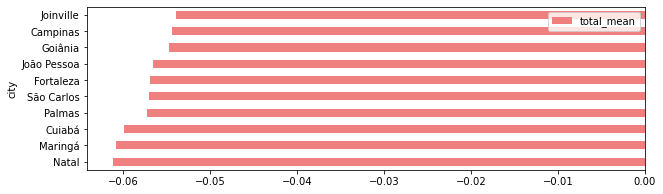

In [95]:
df_cities_neg = df_cities_cases_date.sort_values(by=['total_mean'], ascending=True)[:10]
df_cities_neg.plot(kind='barh', x='city', y='total_mean', figsize=(10, 3), color='lightcoral')

10 cidades com **maiores médias** de sentimentos

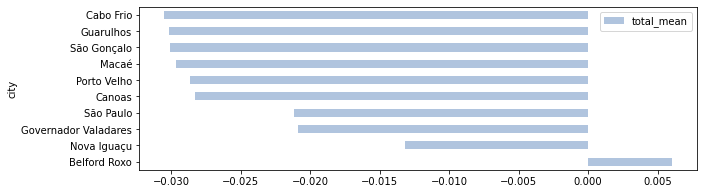

In [96]:
df_cities_pos = df_cities_cases_date.sort_values(by=['total_mean'], ascending=False)[:10]
df_cities_pos.plot(kind='barh', x='city', y='total_mean', figsize=(10, 3), color='lightsteelblue')

**Boxplots**

10 cidades com **menores médias** de sentimentos

In [97]:
df_cities_neg['total_mean'].describe()

count    10.000000
mean     -0.057312
std       0.002616
min      -0.061176
25%      -0.059295
50%      -0.057032
75%      -0.055243
max      -0.053977
Name: total_mean, dtype: float64

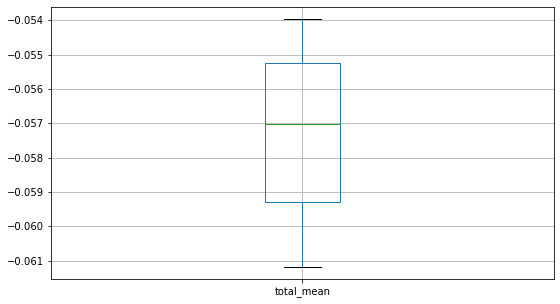

In [98]:
boxplot = df_cities_neg.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

10 cidades com **maiores médias** de sentimentos

In [99]:
df_cities_pos['total_mean'].describe()

count    10.000000
mean     -0.022680
std       0.011585
min      -0.030501
25%      -0.030010
50%      -0.028499
75%      -0.020988
max       0.006020
Name: total_mean, dtype: float64

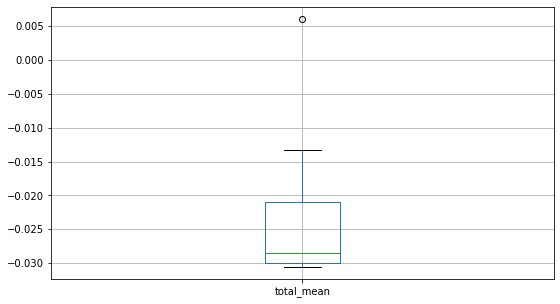

In [100]:
boxplot = df_cities_pos.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

**Gráfico de Barras**

In [101]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Cidades com **menores médias** de sentimentos

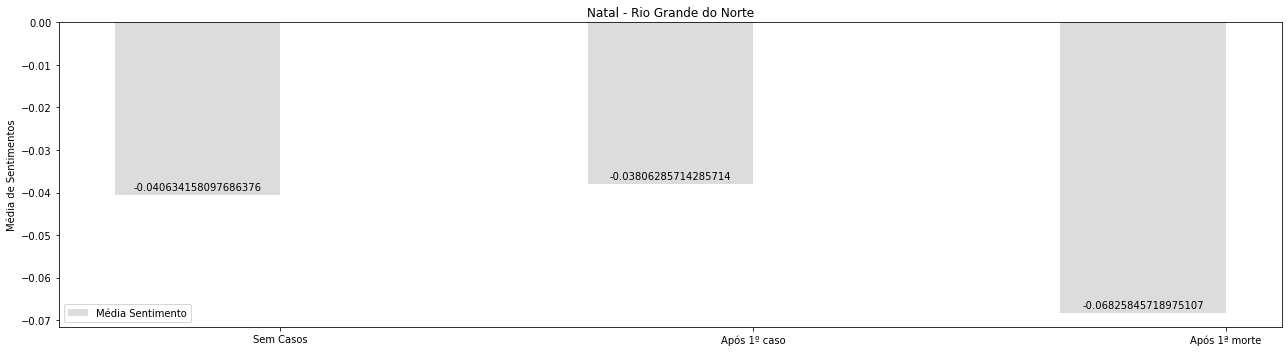

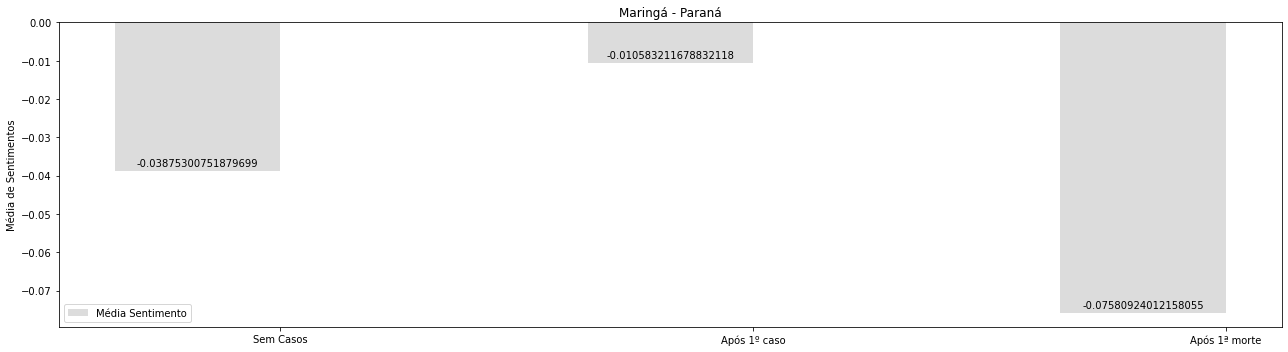

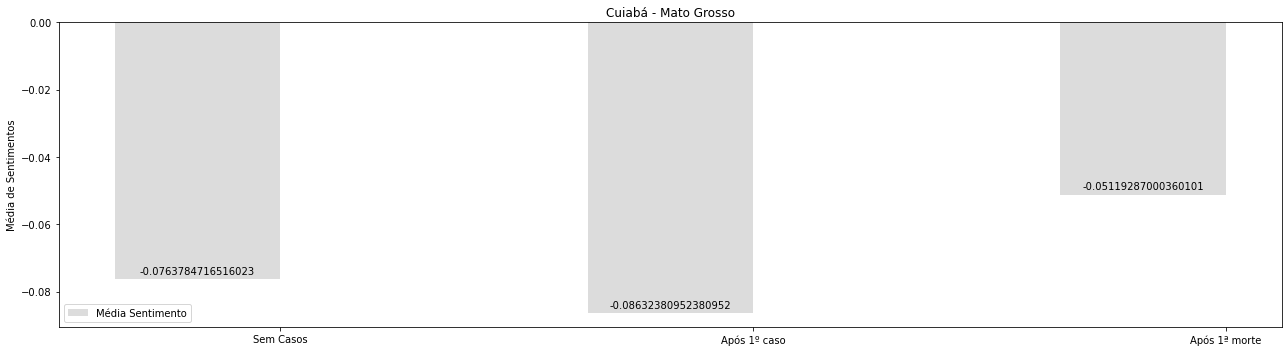

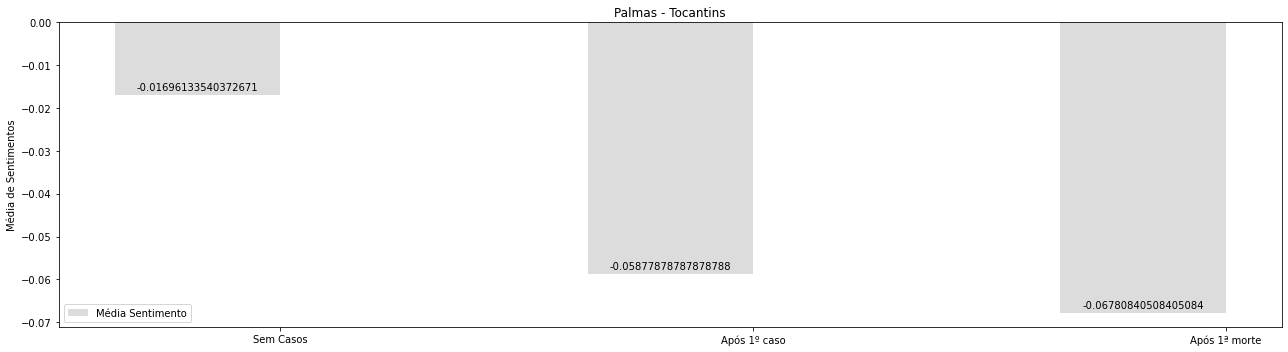

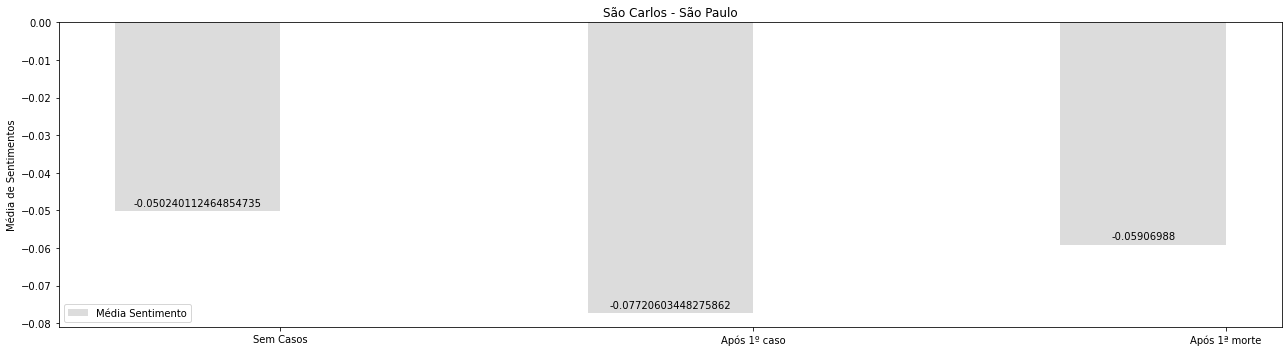

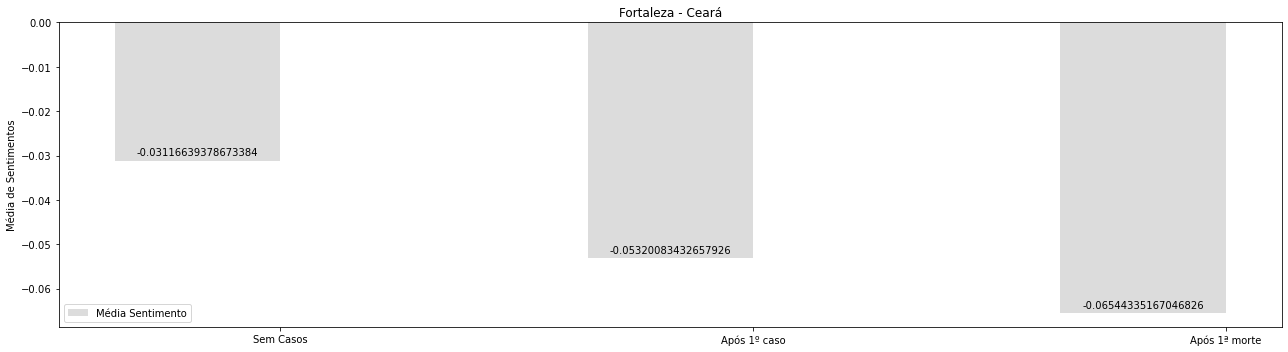

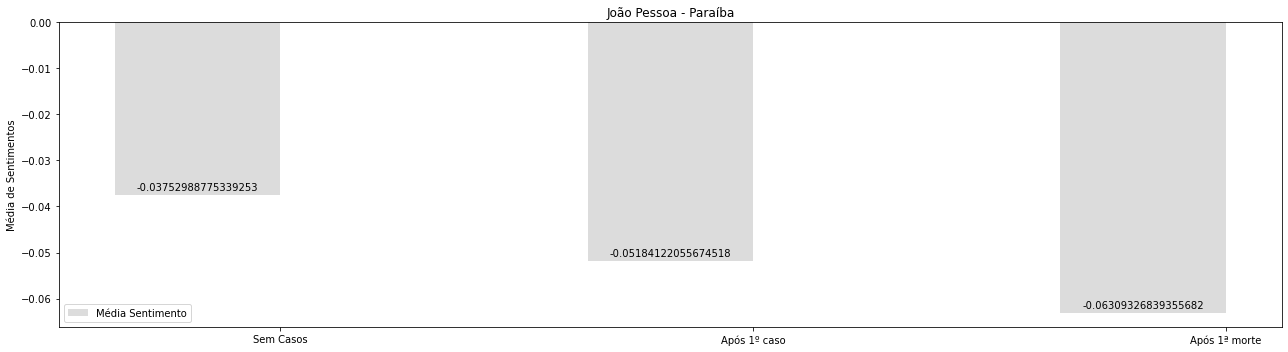

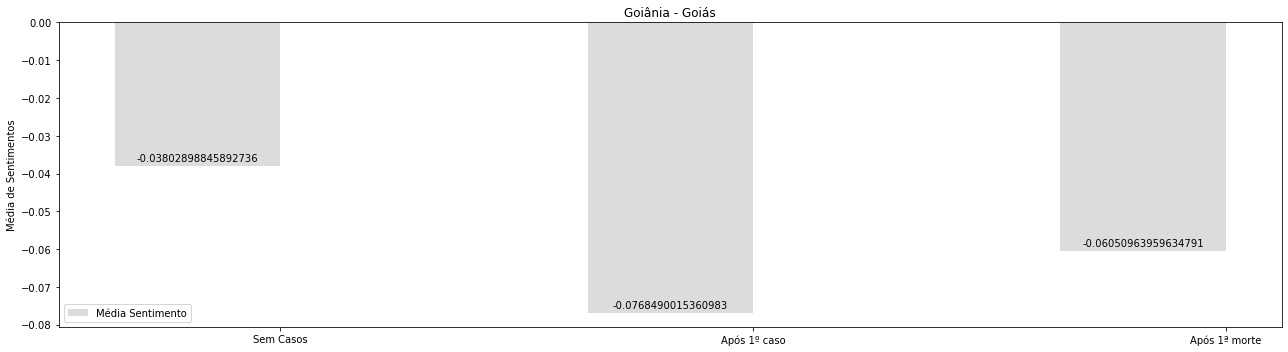

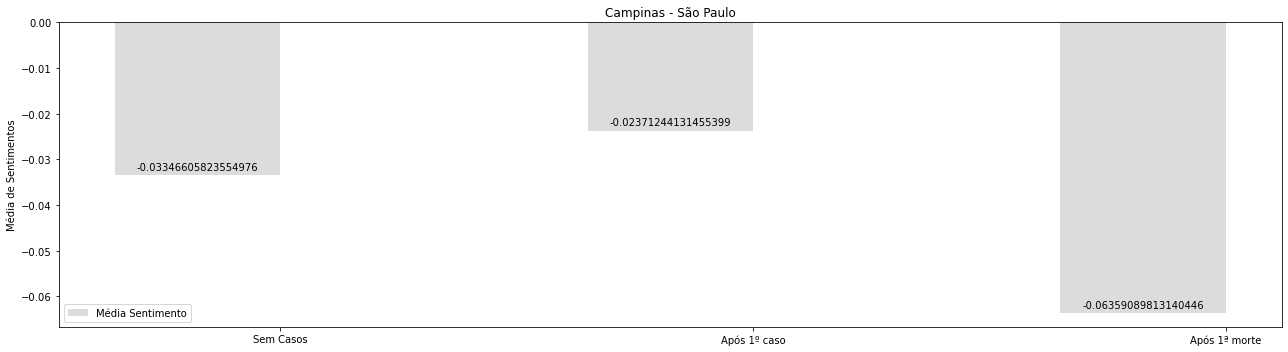

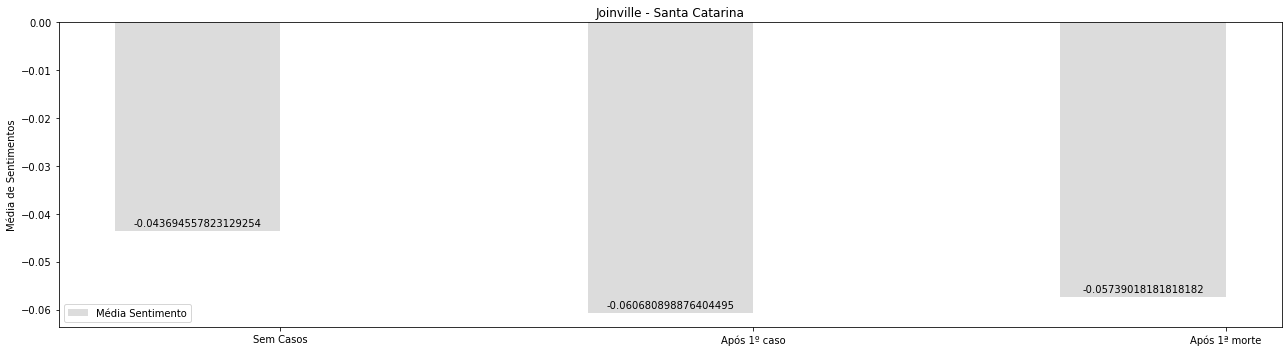

In [102]:
for index, row in df_cities_neg.iterrows():
    
    city = row['city']
    state = row['state']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city + ' - ' + state)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

Cidades com **maiores médias** de sentimentos

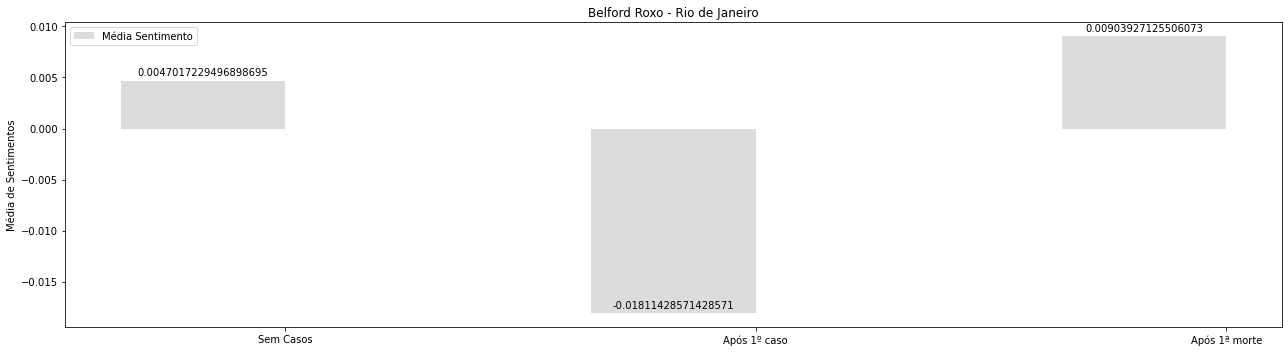

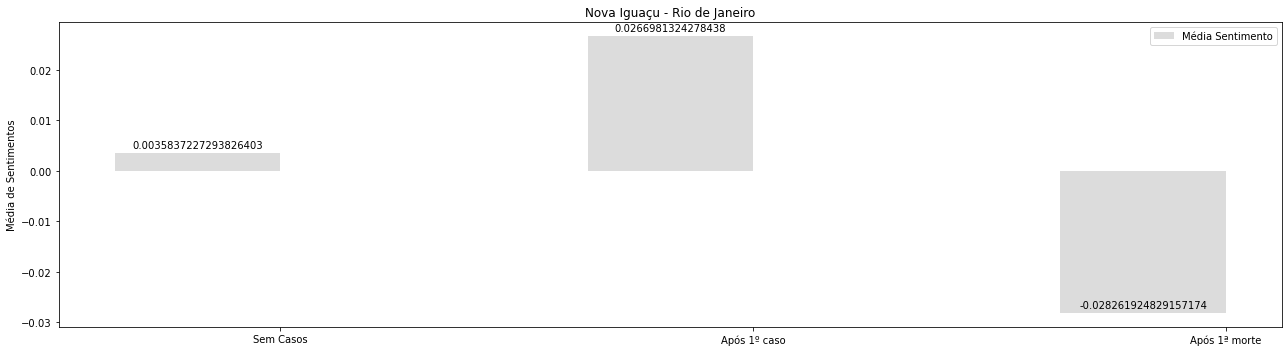

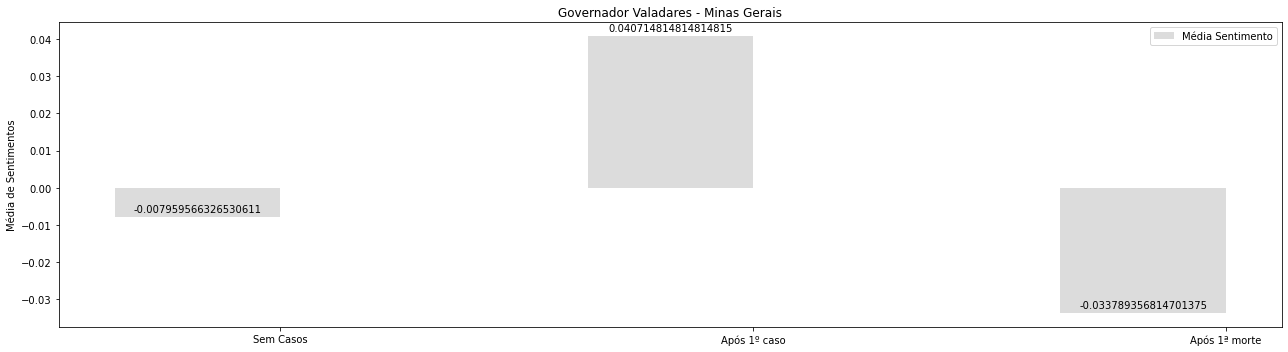

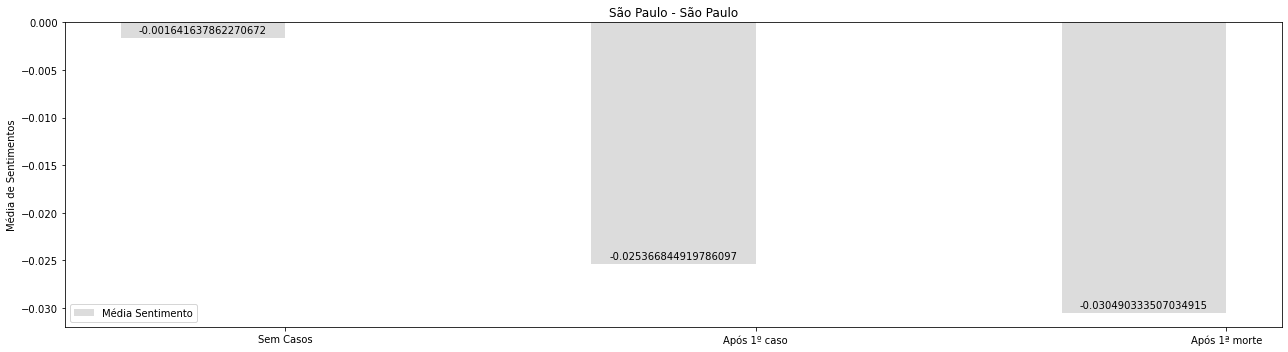

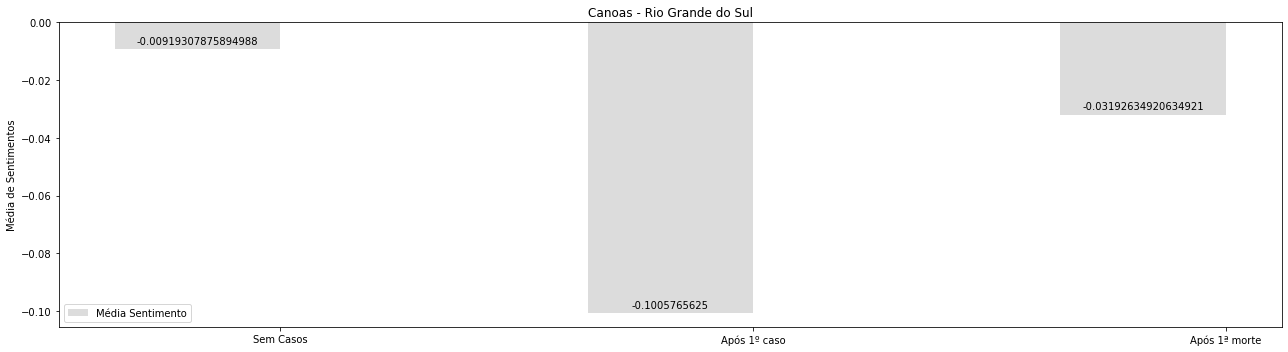

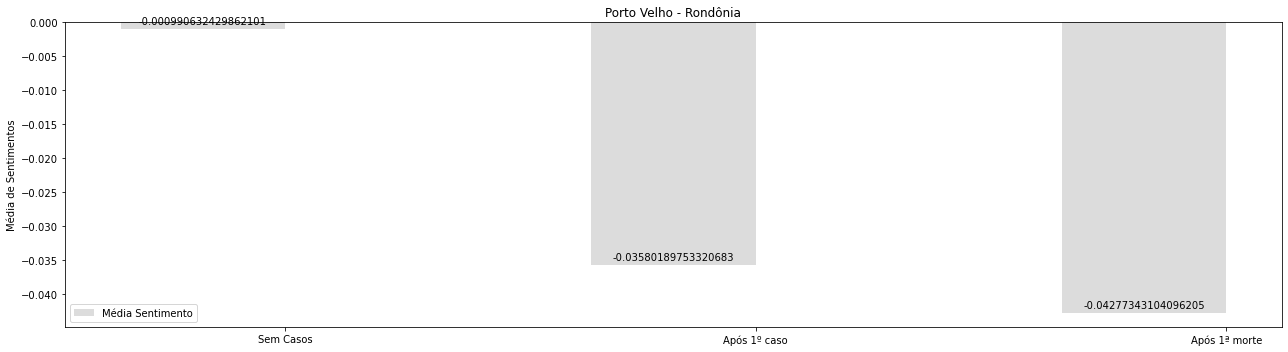

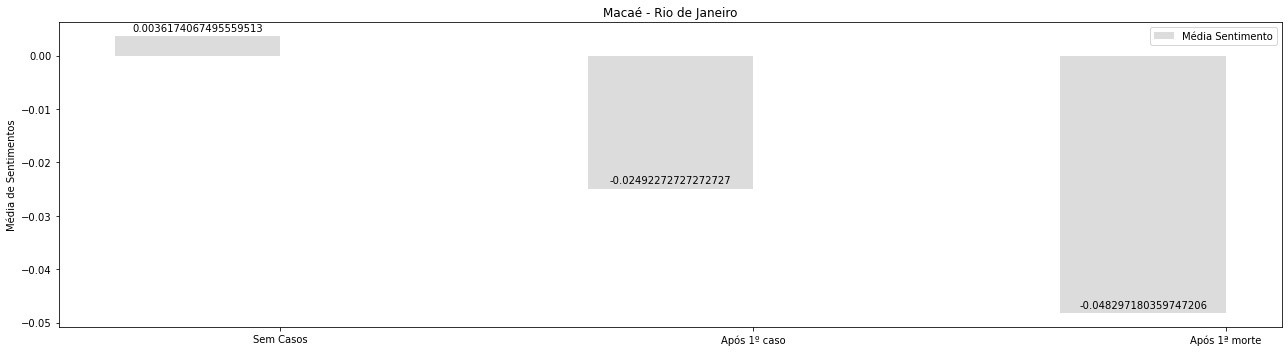

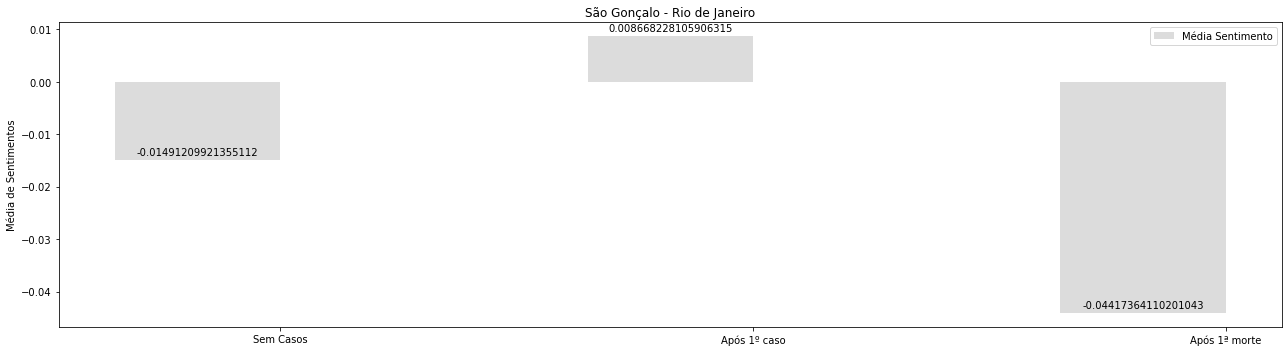

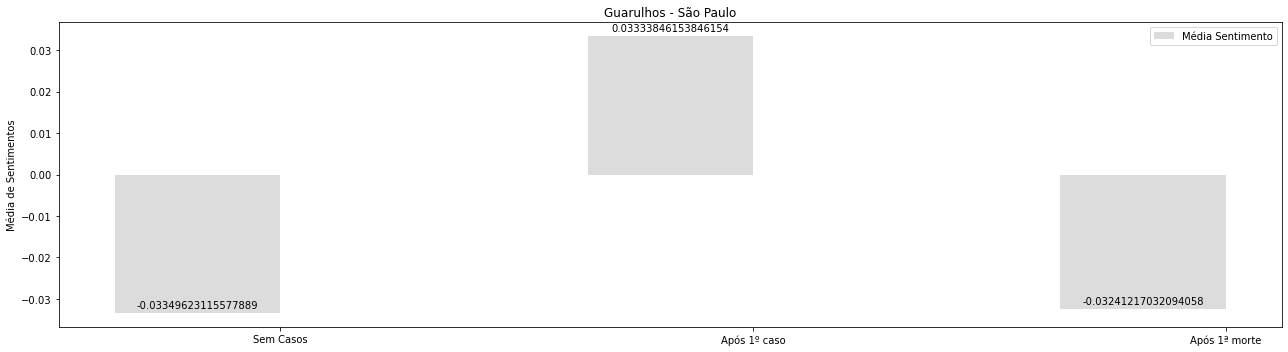

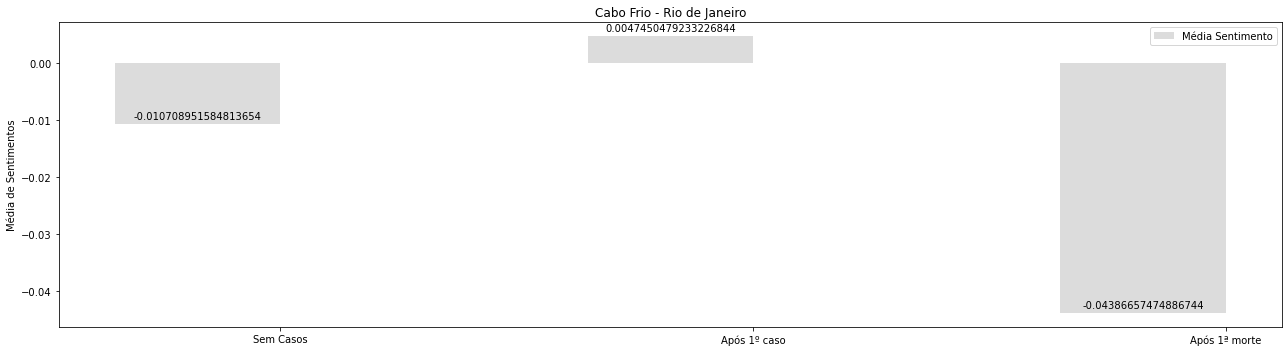

In [103]:
for index, row in df_cities_pos.iterrows():
    
    city = row['city']
    state = row['state']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city + ' - ' + state)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

**Média de sentimento por dia**

In [104]:
def generate_daily_graphic(df, df_brasil):
    
    for index, row in df.iterrows():
    
        city = row['city']
        state = row['state']
        first_case_date = row['first_case_date']
        first_death_date = row['first_death_date']

        df_city = df_brasil.query('city == "'+city+'"')
        df_scores_city = fresults.building_dates_df(df_city, 'score')

        x = df_scores_city.created_at
        y = df_scores_city.score_mean

        color = 'dimgrey'

        label = 'Médias'
        xLabel = 'Data'
        yLabel = 'Médias'

        title = city + ' - ' + state

        fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, '2020-02-01', first_case_date, first_death_date)

Cidades com **menores médias** de sentimentos

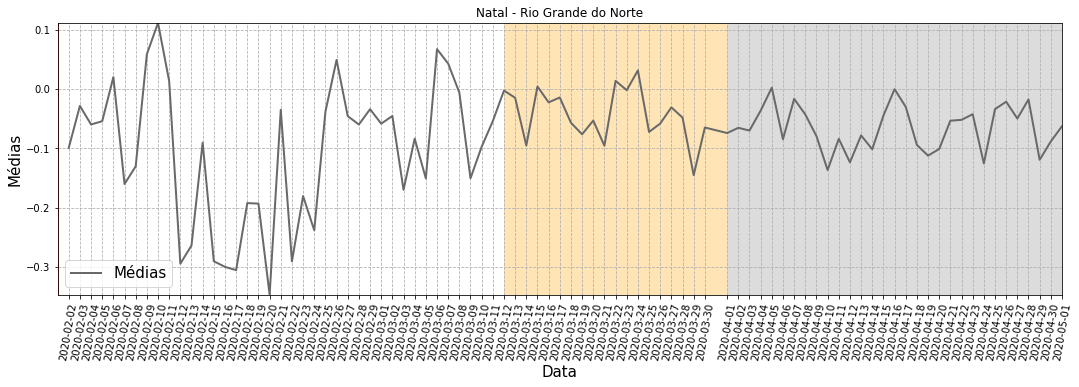

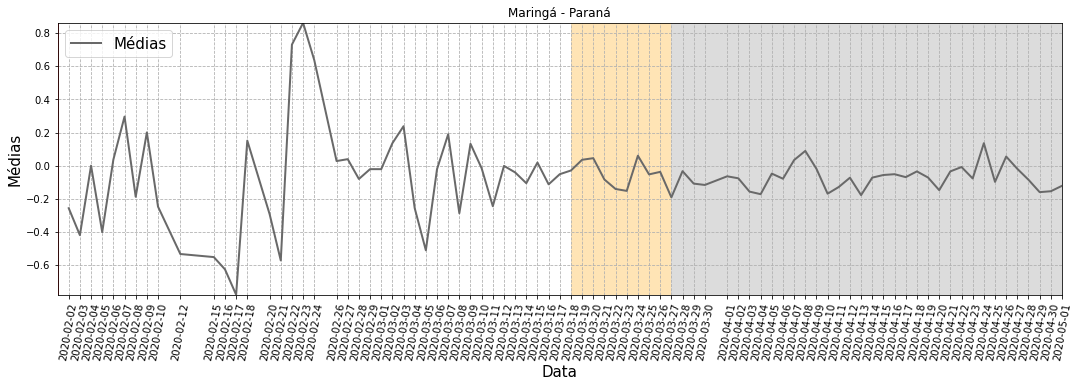

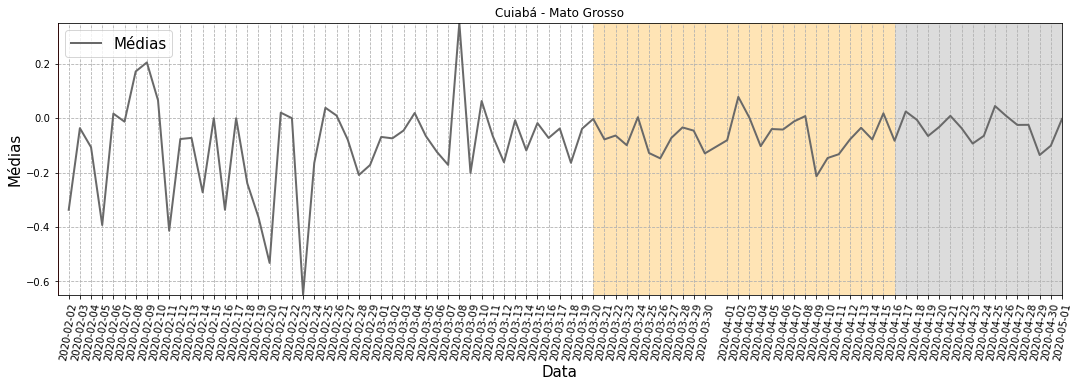

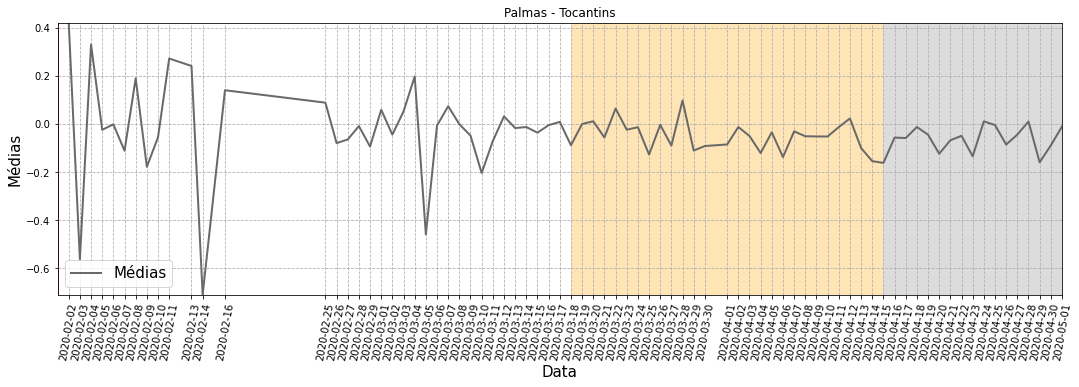

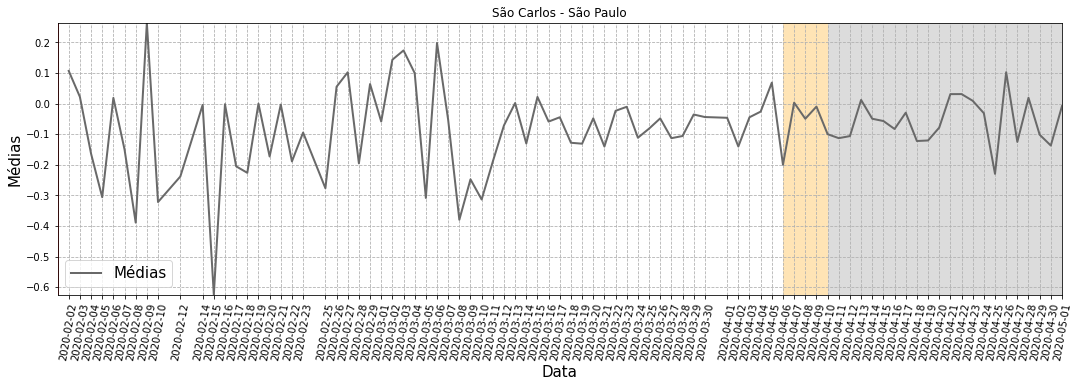

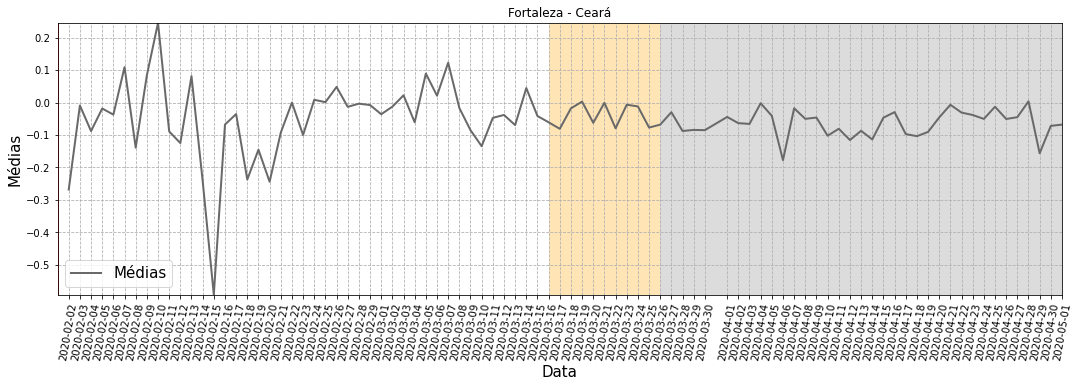

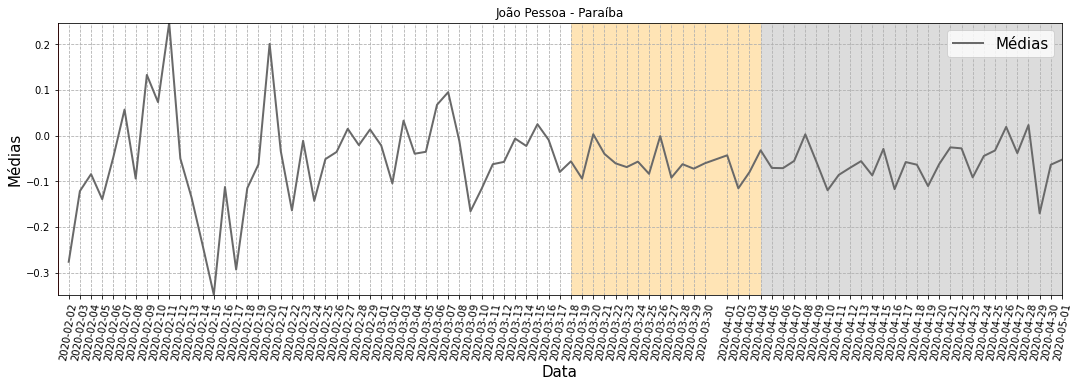

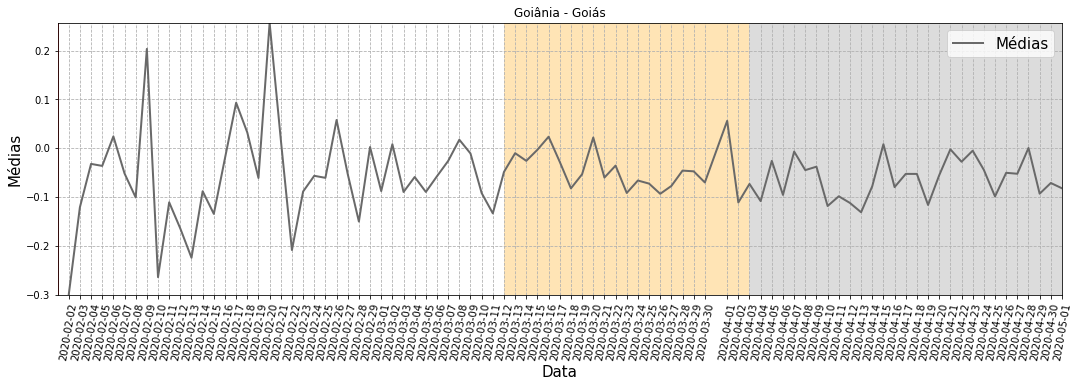

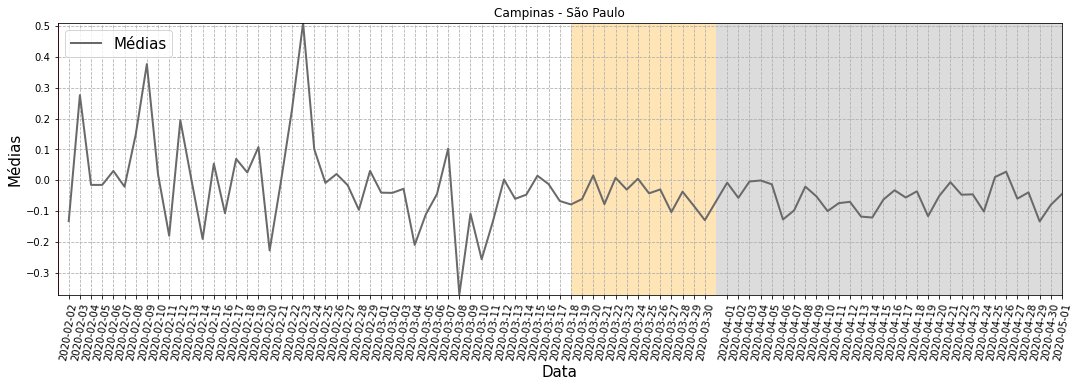

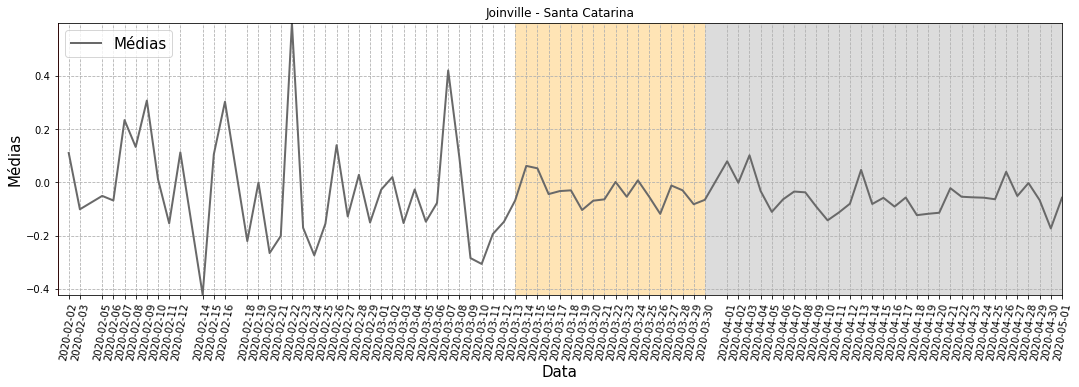

In [105]:
generate_daily_graphic(df_cities_neg, df)

Cidades com **maiores médias** de sentimentos

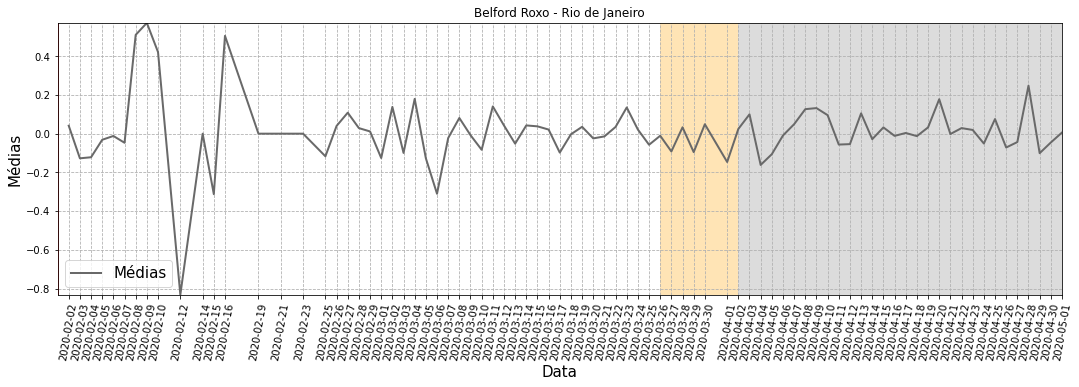

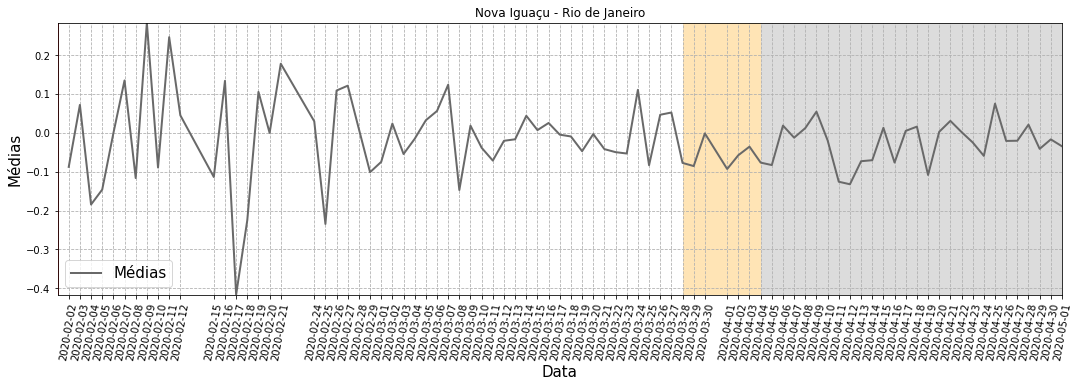

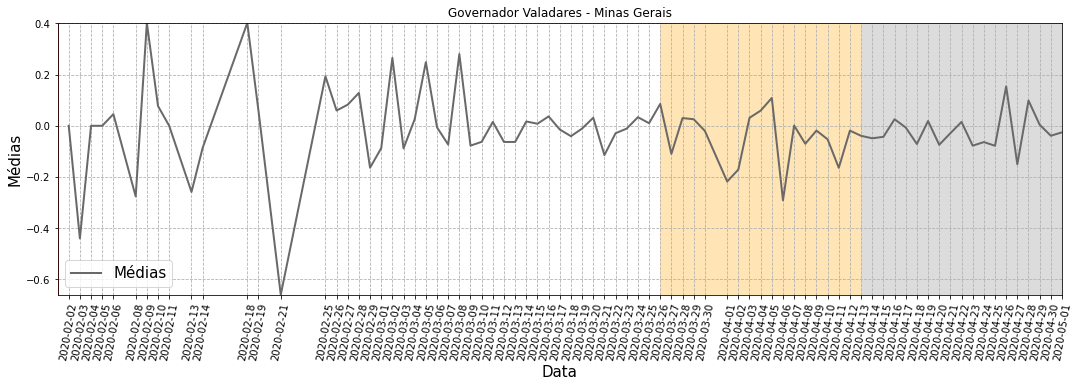

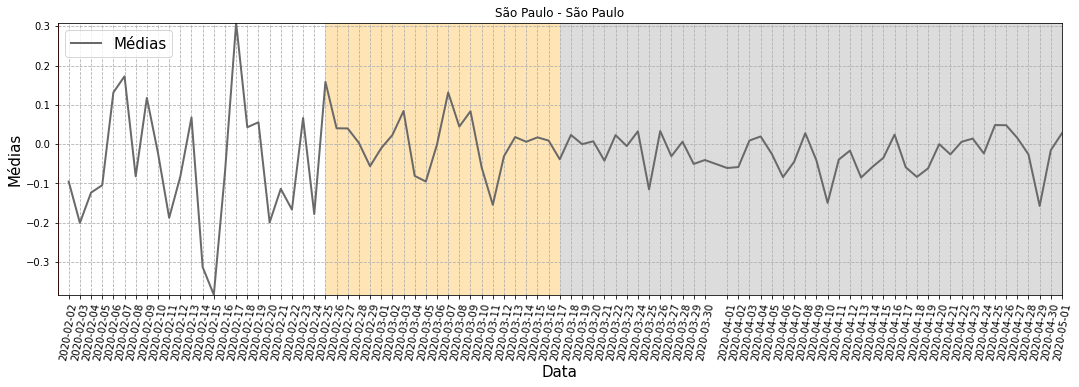

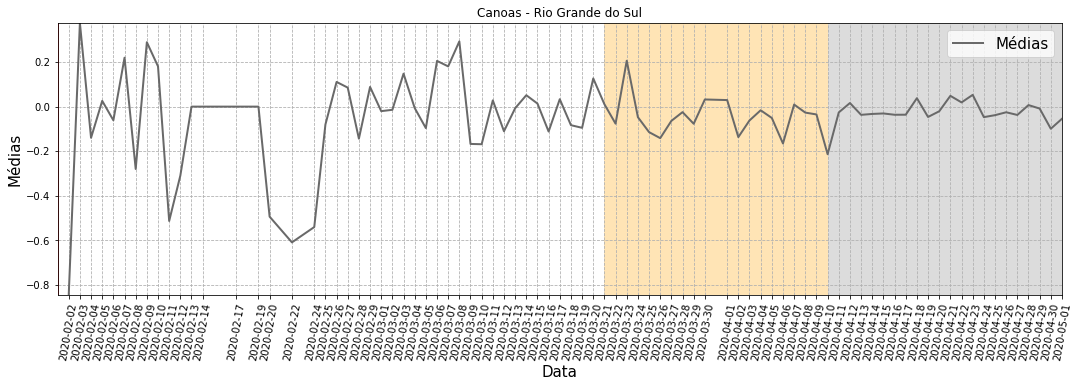

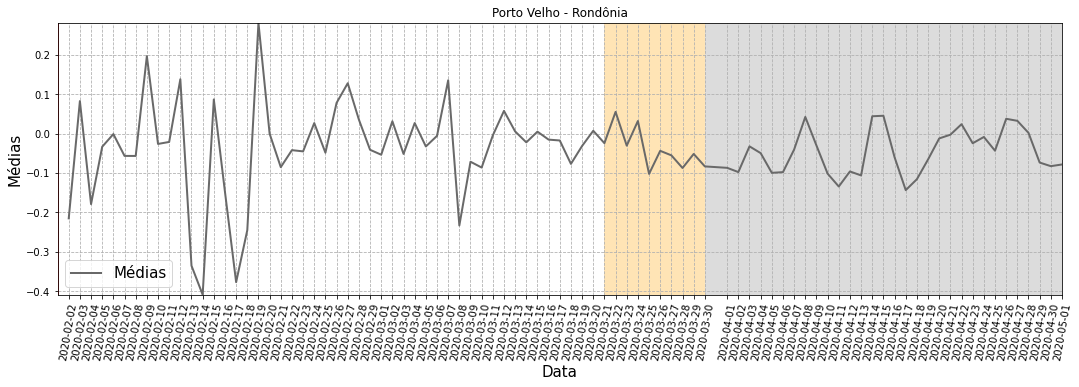

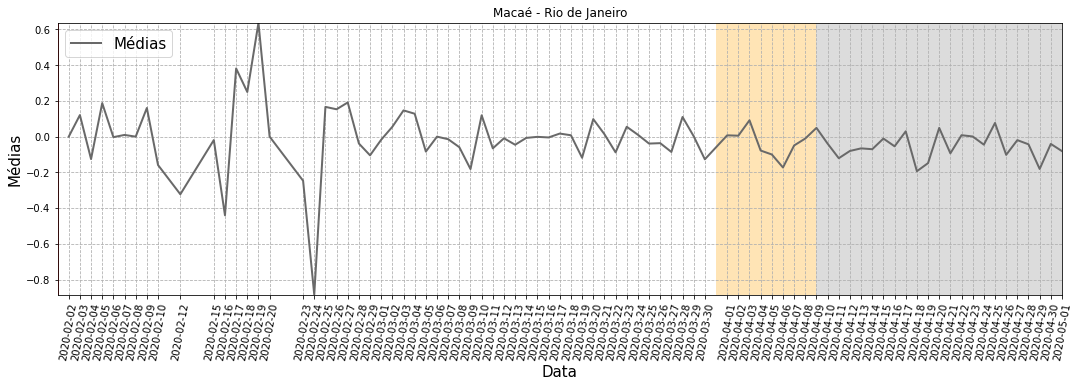

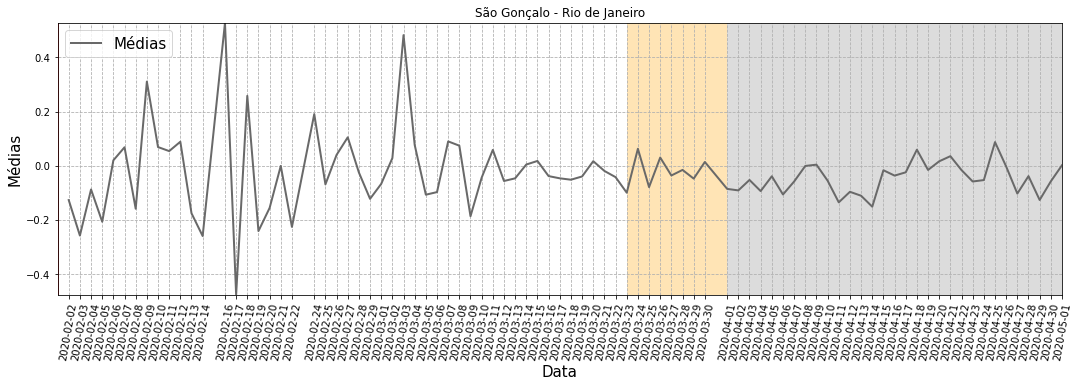

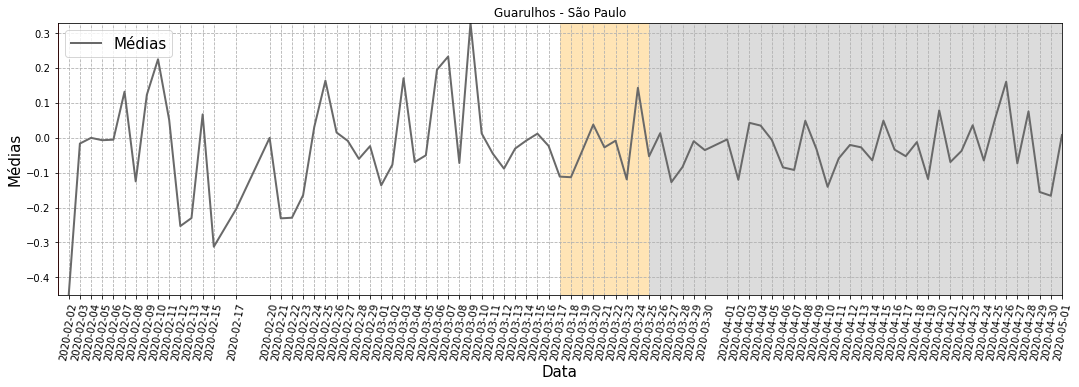

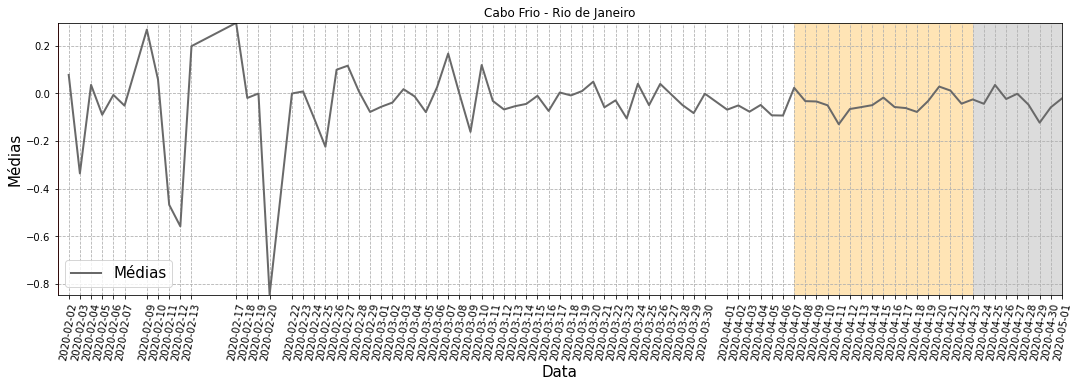

In [106]:
generate_daily_graphic(df_cities_pos, df)

In [107]:
def return_tokens(df, column, max_items):
    
    all_tokens = []
    
    df_tokens = pd.DataFrame(columns = ['column', 'total'])

    for index, row in df.iterrows():
        tokens = row[column]
        df_current_tokens = pd.DataFrame(tokens, columns = ['column', 'total'])
        df_tokens = df_tokens.append(df_current_tokens)
        
    df_grouped = df_tokens.groupby('column')['total'].sum()
    
    for index, row in df_grouped.iteritems():
        data = [index, row]
        all_tokens.append(data)

    return all_tokens

In [108]:
def generate_bar_from_tokens_freq(tokens_freq, max_res, color, x, y, title):
    
    if len(tokens_freq) > 0:           
        df_words = pd.DataFrame(tokens_freq, columns=['column','total'])
        df_words = df_words.sort_values(by = ['total'], ascending=[False])
        df_words[:max_res].plot(kind='barh', x='column',y='total', figsize=(x, y), color=color, title=title)

In [109]:
from IPython.display import HTML, display
import tabulate

In [110]:
max_res = 5

**Palavras presentes nos tweets que mais influenciaram negativamente/positivamente**

Primeiro Período (Sem Casos)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

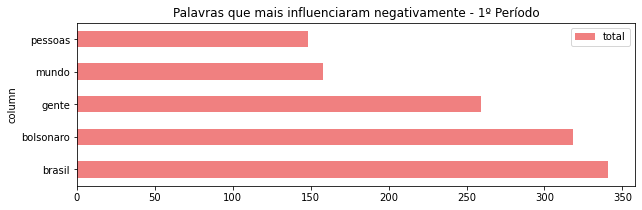

In [111]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg1', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

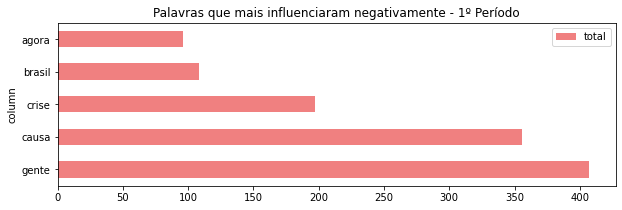

In [112]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg1', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

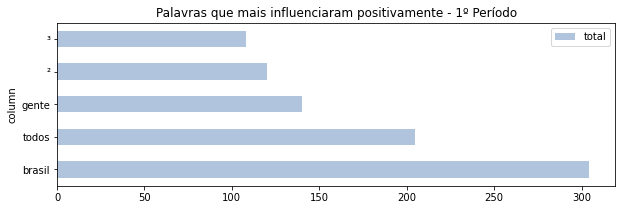

In [113]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos1', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

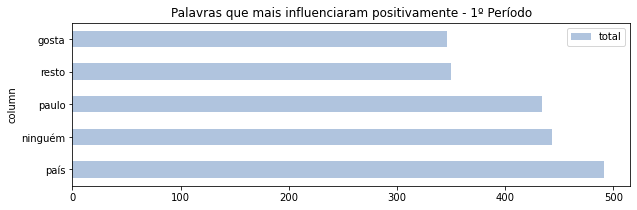

In [114]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos1', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

Segundo Período (Após 1º caso)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

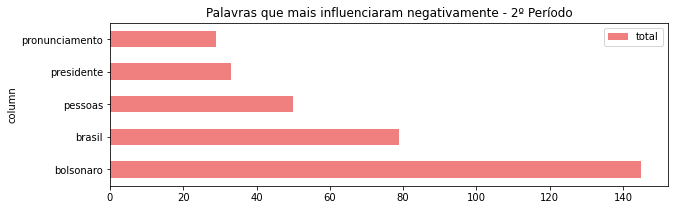

In [115]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg2', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

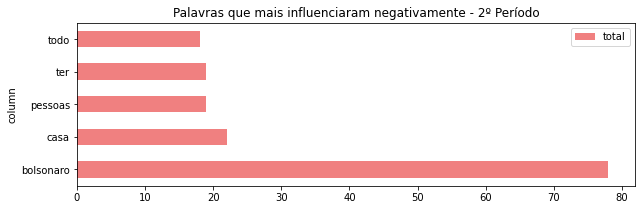

In [116]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg2', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

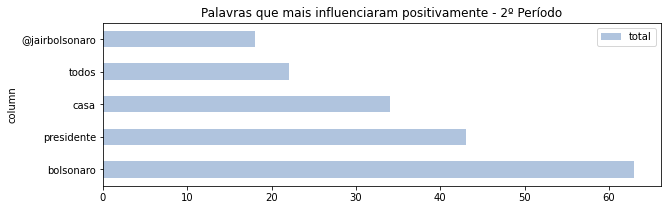

In [117]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos2', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

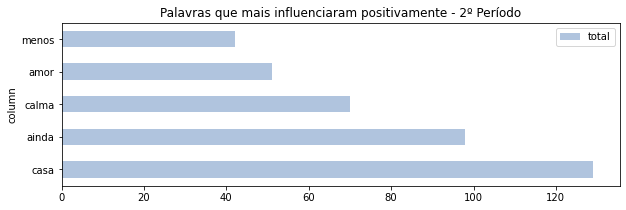

In [118]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos2', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

Terceiro Período (Após 1ª morte)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **negativamente**

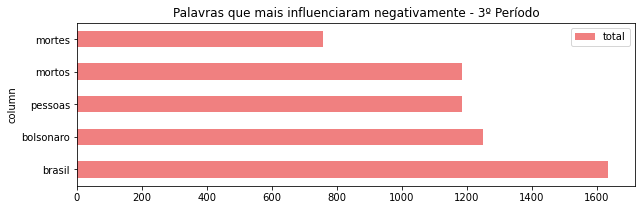

In [119]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg3', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **negativamente**

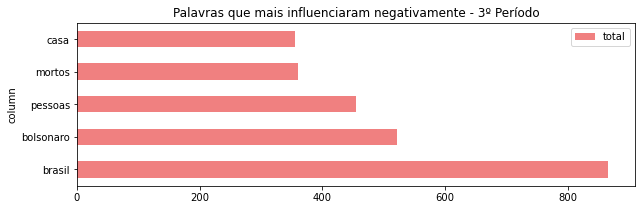

In [120]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg3', max_res)
generate_bar_from_tokens_freq(all_tokens_neg, max_res, 'lightcoral', 10, 3, title)

- Cidades com **menores médias** de sentimentos - Palavras que influenciam **positivamente**

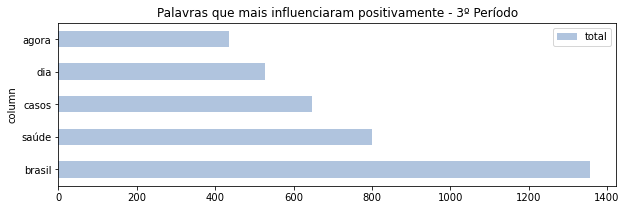

In [121]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos3', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

- Cidades com **maiores médias** de sentimentos - Palavras que influenciam **positivamente**

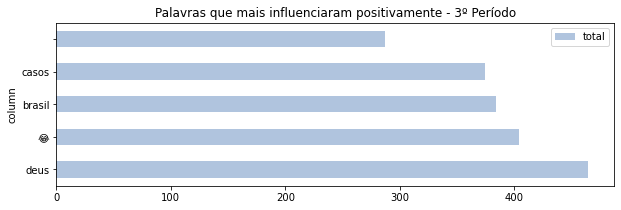

In [122]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos3', max_res)
generate_bar_from_tokens_freq(all_tokens_pos, max_res, 'lightsteelblue', 10, 3, title)

**Retweets**

Cidades com **menores médias** de sentimentos

**Frases negativas** mais retweetadas

In [123]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_neg1']), tablefmt='html')))

"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 8)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 6)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 6)","('RT @oatila: Olha só, dois artigos, de 2015 e 2016, antevendo o coronavírus como um problema futuro. São previsões baseadas em dados e no mé…', 4)","('RT @zanalivia: notícia oficial vinda do grupo de alunos da geografia usp sobre o caso de coronavirus: \n\no aluno infectado pegou o virus da…', 4)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 6)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 4)","('RT @ly_carr: O coronavirus antes de qualquer coisa é um justiceiro', 4)","('RT @pefabiodemelo: Posso até não pegar o corona, mas louco eu fico.', 3)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 2)"
"('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 6)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 5)","('RT @zanalivia: notícia oficial vinda do grupo de alunos da geografia usp sobre o caso de coronavirus: \n\no aluno infectado pegou o virus da…', 5)","('RT @Poconemilgrau: Já agradeceu hoje por morar em Mato Grosso? Não tem enchente, coronavirus e ameaça de guerra. Só fofoqueiros, mas já est…', 4)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 2)"
"('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 2)","('RT @bomdiaricardo: A culpa é dos jornalistas\nA culpa é do Corona Vírus \nA culpa é da Guerra Comercial \nA culpa é das empregadas domésticas…', 2)","('Uma doença pior que a outra. Horror! https://t.co/qRFl6P9yco', 1)","('Segue a thread. Jornalixo da Foice deveria ser considerado crime e sofrer punições! https://t.co/YGluVtRpKk', 1)","('Uns coitados, em um cruzeiro é sacanagem. https://t.co/nDiDVzf7q7', 1)"
"('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 8)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 5)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 4)","('RT @TkngSatellites: A matéria acumulada chegando depois que a crise do corona acabar', 3)","('RT @baconehruim: nem se preocupa c esse coronavirus ai....a saudade dela mata bem mais', 2)"
"('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 18)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 11)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 9)","('RT @TatiNefertari: Em feira de santana uma empregada doméstica foi contaminada com corona pela patroa e transmitiu pra mãe idosa\n\nNo Rio me…', 5)","('RT @josilas: COLETA EXAME DE COVID-19 NO CEARÁ\n1. Hospital Monte Klinikun (particular)\nHospital Regional Unimed (Particular)\nHospital São…', 5)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 18)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 14)","('RT @TatiNefertari: Em feira de santana uma empregada doméstica foi contaminada com corona pela patroa e transmitiu pra mãe idosa\n\nNo Rio me…', 11)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 8)","('RT @gabylucasss: se o corona vírus cancelar as festas juninas, ai vamos ter que partir pra violência', 8)"
"('RT @nicoIodi: esse apelido aí pro presidente eu já achei

In [124]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_neg2']), tablefmt='html')))

"('RT @KennedyAlencar: Pronunciamento de Bolsonaro é irresponsável: mentiu ao dizer que covid-19 ""brevemente passará"". É criminoso: colocou-se…', 4)","('RT @folha: Histórico de atleta não impediu campeão olímpico de sofrer com coronavírus https://t.co/CrT86AFfPJ', 4)","('RT @flavioemel: Sou bióloga e já trabalhei com vírus nível 3 como o Corona! Desde quando precisa parar a economia e ficar enclausurado???…', 4)","('RT @jnascim: VALE VER: No @JornalDaGlobo, @renataloprete repassa e contesta praticamente todo o (lamentável) pronunciamento de Bolsonaro de…', 3)","('RT @LorenzonItalo: Estamos nos aproximando de 15000 mortes MUNDIAIS pelo Corona Vírus. Mais ou menos o que morria no Brasil de assassinato…', 2)"
"('RT @ArthurWeint: O Brasil já estava decolando no 4o trimestre de 2019. A epidemia de Covid-19 veio como um urubu na turbina, nos obrigando…', 1)","('@gabriela_perin não é nem por isso gata, o dono do bagulho é contra o isolamento do corona vírus, falo que todo mundo tem que trabalha memo, e que é melhor chorar pela morte de alguém doque de quebrar o brasil', 1)","('tive contato com um cara que é suspeito de corona........\neu vô morre😭', 1)","('RT @BetoSilvaBR: COVID-19 é a arma que os ABUTRES precisavam para os seus interesses doentios. Depois de 14 anos saqueando o país, não é fá…', 1)","('kkkkk o cu fechou nessa hora mas coitados mal sabiam..... um mês depois e mais de 2 mil confirmados https://t.co/GJCwZOvLha', 1)"
"('RT @ArthurWeint: O Brasil já estava decolando no 4o trimestre de 2019. A epidemia de Covid-19 veio como um urubu na turbina, nos obrigando…', 1)","('@asarabellaohhh Quando o corona passar vc vem segurar ela no colo, pq até hj vc n teve essa sorte', 1)","('RT @Clauwild1: “Trump está certo sobre o Coronavirus. A OMS está errada”, diz especialista de Israel. O virologista Dan Yamin desenvolveu m…', 1)","('O preso em questão, trabalha fora da unidade e volta às celas depois da jornada. #Rdnews https://t.co/4seXvxnULJ', 1)","('Doriana comk exemplo? Ou é desconhecimento ou desonestidade.\nAh esqueci. A escolha é mt difícil. https://t.co/VTfOKS2zfM', 1)"
"('RT @flavioemel: Sou bióloga e já trabalhei com vírus nível 3 como o Corona! Desde quando precisa parar a economia e ficar enclausurado???…', 2)","('@lucasrios_10 O Brasil teve 1,5 milhões de infectados em 2019 em decorrência de uma crescente de 600% em relação à 2018. Até fevereiro deste ano já havia registrado alta de 70% em relação à 2019, resultando na morte de 77 pessoas, contra 25 do Corona no mesmo período. É uma obs a ser notada.', 1)","('RT @cleytonsanth: levando em consideração a forma do coronavirus, podemos dizer que são mamonas assassinas?? https://t.co/7AnzyVDYj2', 1)","('Foram suspensos apenas os prazos, pedir ainda pode, no entanto, caso os agentes (1) precisem ir ao órgão buscar os dados (2) estejam em regime de quarentena (3) esteja atuando na linha de frente do combate ao Corona, os prazos serão suspensos.', 1)","('MPTO alerta que é crime descumprir as determinações do poder público para contenção do coronavírus https://t.co/Bell8yVWsN', 1)"
"('RT @CalcinhasNoBox: ""NO COMBATE AO COVID-19\nXuxa q tem Pacto Com Satanás doou 1 Milhão de Reais\nRihanna que é Maconheira doou 8 Milhões de…', 4)","('RT @jnascim: VALE VER: No @JornalDaGlobo, @renataloprete repassa e contesta praticamente todo o (lamentável) pronunciamento de Bolsonaro de…', 2)","('@revistaoeste Mentira, o corona vírus já está em 200 países. E matou quase 15000 em 3 meses.', 1)","('Corona fudeu com todos os meus planos, aff', 1)","('RT @fontouras_: Oq mata é a sdd do CTG, coronavirus só deixa mal', 1)"
"('RT @CalcinhasNoBox: ""NO COMBATE AO COVID-19\nXuxa q tem Pacto Com Satanás doou 1 Milhão de Reais\nRihanna que é Maconheira doou 8 Milhões de…', 5)","('RT @flavioemel: Sou bióloga e já trabalhei com vírus nível 3 como o Corona! Desde quando precisa parar a economia e ficar enclausurado???…', 4)","('RT @camposmello: Hospital que atendeu Bolsonaro diz que dois nomes em lista de co

In [125]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_neg3']), tablefmt='html')))

"('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 21)","('RT @oatila: Pelo menos 189 pessoas infectadas com COVID-19 em um frigorífico em Wisconsin. Tiveram que fechar. Lições: \nSe você não fechar,…', 12)","('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 10)","('RT @andreawerner_: “A fome vai matar muito mais que o covid”, diz o povo que sempre foi contra bolsa família.', 9)","('RT @gilmarmendes: A crise do #coronavirus só vai ser superada com responsabilidade política, união de todos e solidariedade. Invocar o AI-5…', 9)"
"('RT @changemdm: lembram quando o Borsalino mostrou mais empatia por uma estátua da havan queimada do que pelos 5 mil mortos por COVID-19? ht…', 5)","('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 4)","('RT @FeCastanhari: Em meio ao CAOS que estamos vivendo Bolsonaro decide demitir um dos únicos ministros que vem fazendo um ótimo trabalho a…', 3)","('RT @abrunanaopensa: sinceramente eu fico MORTA DE PREGUIÇA pra não dizer PUTA desse discurso de ""ai o corona veio pra nos fazer desacelerar…', 3)","('RT @VilenaRuth: Apenas o 4° mês de 2020, e já tivemos:\n- Queimadas\n- Conflito entre EUA x IRÃ quase causando a terceira guerra mundial\n- Pa…', 3)"
"('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 5)","('RT @laylarobert_a: É isso mesmo: voce que fica ai sofrendo por nao aguentar ficar em casa e precisa e da um rolezinho na casa do seu amigo…', 4)","('RT @paularsa: Sabe quando as pessoas negligentes e irresponsáveis vão levar a sério o COVID-19 ? Quando pessoas da família deles estiverem…', 4)","('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 4)","('RT @oatila: Pelo menos 189 pessoas infectadas com COVID-19 em um frigorífico em Wisconsin. Tiveram que fechar. Lições: \nSe você não fechar,…', 4)"
"('RT @robertatum: Dez em dez sendo enterrados em Manaus. Vítimas da Covid 19. Aquela coisa que segundo os lunáticos não existe, é golpe da Ch…', 4)","('RT @dannlelis: Aquele médico palmense que divulgou um vídeo minimizando a pandemia de covid-19 teve o registro profissional suspenso cautel…', 4)","('RT @dannlelis: Tocantins registrou, hoje, a PRIMEIRA MORTE por covid-19. Servidora da Secretaria Municipal de Saúde, a assistente social Fr…', 3)","('RT @dannlelis: Não importa se você acha que a covid-19 pode ou não matar, ELA PODE SIM. Não é questão de opinião. É Ciência.', 3)","('RT @dannlelis: Pelo menos dois casos de covid-19, em Palmas, em que as pessoas diagnosticadas NÃO TÊM IDEIA de onde se infectaram. Não viaj…', 3)"
"('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 5)","('RT @abrunanaopensa: sinceramente eu fico MORTA DE PREGUIÇA pra não dizer PUTA desse discurso de ""ai o corona veio pra nos fazer desacelerar…', 4)","('RT @clexapride: coronavirus não pode me matar porque eu morri no dia que lexa e lincoln morreram https://t.co/2kR61UBzhK', 4)","('RT @_Gaucha__: Adolescente de 15 anos morreu hoje por causa do coronavirus e tu aí não consegue se segurar na porra da tua casa porque prec…', 3)","('RT @DPLNacional: Testes da #Hidroxicloroquina estão sendo realizados em pacientes de #COVID19, mas ainda ñ há comprovação científica de sua…', 3)"
"('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 30)","('RT @gerdwenzel: Se Angela Merkel, ao ser confrontada com o número de vítimas fatais por causa do covid-19, respondesse - ""Na und?"" (E daí?)…', 21)","('RT 

**Frases positivas** mais retweetadas

In [126]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_pos1']), tablefmt='html')))

"('RT @micharnot: apoie o vírus local', 8)","('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 7)","('RT @fran_becher: A TERRA é redonda (geoide, pra ser exata).\n\nO NAZISMO é de extrema-direita, como o PSL.\n\nVACINA é essencial e não causa au…', 6)","('RT @porrarandas: Pq se depender da saúde pública brasileira... Todos terão acesso a tratamento gratuita e caso necessário será feito uma ca…', 5)","('RT @kleriene18: Aqui vc não só faz o exame pro corona vírus mas tbm teste rápido de\nHIV \nSífilis \nHepatite B\nHepatite C \nTodos de GRAÇA na…', 5)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 7)","('RT @Astronomiaum: As brasileiras que sequenciaram o genoma do coronavírus\n✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾✊🏾 Mulheres na ciência! Eeee.... Que orgulho!…', 4)","('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 3)","('RT @oicoutinho: sim amores, a confirmação de mais um caso de coronavirus no brasil vai ser passada via grupo de wpp por SEI LÁ QUEM e não p…', 3)","('RT @rapfalando: so vem da bom dia se vc descobriu a cura do coronavirus ou tem uma proposta milionaria na mao \n\nde resto o resumo eh o de s…', 3)"
"('RT @micharnot: apoie o vírus local', 5)","('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 3)","('RT @VittorGuidoni: mal posso esperar pra fazerem a vacina do Coronavirus, o SUS mobilizar o programa de vacinação e resolver tudo de uma ve…', 2)","('RT @fran_becher: A TERRA é redonda (geoide, pra ser exata).\n\nO NAZISMO é de extrema-direita, como o PSL.\n\nVACINA é essencial e não causa au…', 2)","('RT @kleriene18: Aqui vc não só faz o exame pro corona vírus mas tbm teste rápido de\nHIV \nSífilis \nHepatite B\nHepatite C \nTodos de GRAÇA na…', 2)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 3)","('RT @samiacayres: Qual a ligação entre o Coronavirus e os algoritmos de inteligência artificial (IA)? \nDescubra no Programa EducAção desta q…', 2)","('RT @JefinhoMenes: Dr. Drauzio não se preocupe com o coronavirus porque se ele infectar o senhor eu dou um pulmão pro senhor respirar', 2)","('RT @kleriene18: Aqui vc não só faz o exame pro corona vírus mas tbm teste rápido de\nHIV \nSífilis \nHepatite B\nHepatite C \nTodos de GRAÇA na…', 2)","('RT @marveIdevil: ""evitem se beijar para prevenção do coronavirus""\n\nultima vez que eu beijei alguem:', 2)"
"('RT @JefinhoMenes: Dr. Drauzio não se preocupe com o coronavirus porque se ele infectar o senhor eu dou um pulmão pro senhor respirar', 6)","('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 5)","('RT @oraporra: amiga depois do coronavirus vamos marca', 5)","('RT @eoygu_: corona tá aí, parem com o aperto de mão e usem😗✌️', 5)","('RT @fran_becher: A TERRA é redonda (geoide, pra ser exata).\n\nO NAZISMO é de extrema-direita, como o PSL.\n\nVACINA é essencial e não causa au…', 4)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 15)","('RT @minsaude: Para proteger você e sua família é preciso ter atenção e cuidado. Fique atento aos sintomas e às formas de transmissão e prev…', 12)","('RT @micharnot: apoie o vírus local', 11)","('RT @naosalvo: Ces viram a matéria do cara com coronavirus em SP?\nEle passou 4 dias no carnaval\nFoi no Ibirapuera\nCompartilhou loló com desc…', 10)","('RT @JefinhoMenes: Dr. Drauzio não se preocupe com o coronavirus porque se ele infectar o senhor eu dou um pulmão pro senhor respirar', 10)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 22)","('RT @micharnot: apoie o vírus local', 19)","('RT @kleriene18: Aqui vc não só faz o exame pro corona vírus mas tbm teste rápido de\nHIV \nSífilis \nHepatite B\nHepatite C \nTodos de GRAÇA na…', 19)","('RT @JefinhoMenes: Dr. Drauzio não se preocupe com o coronavirus

In [127]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_pos2']), tablefmt='html')))

"('RT @fatimabezerra: Meus amigos e minhas amigas, boa noite.\n\nQuero aqui de forma bem direta tranquilizar o povo potiguar. Nós vamos continua…', 11)","('RT @PapaiBozo: NO COMBATE AO COVID-19\n*Xuxa que tem #PactoComSatanás DOOU 1Milhão de Reais\n*Rihanna que é #Maconheira DOOU 8Milhões de Dóla…', 5)","('RT @mariana_godoy: 26 anos e saudável. Fiquem em casa. https://t.co/EnJU8GfuZH', 4)","('RT @luide: URGENTE\n\né GRANDES FORTUNAS\nvocê que tem um corsa e um xiaomi fique tranquilo https://t.co/fmSw5QggsM', 3)","('RT @Jujuca1987: Campeão olímpico dos 100 peito deu declaração da gravidade que foi contrair corona vírus mas bolsonaro com seu HISTÓRICO DE…', 3)"
"('RT @andcwt: Calma ai coronavirus nem fui amado de verdade ainda', 2)","('Hoje saí de casa p fazer um corre e f1, fiquei noiada achando q tudo q encostava podia ter corona\nN saio mais nem fudendo, cerquei real', 1)","('essa mão eu vou ter que soltar e nem é por causa do coronavirus', 1)","('RT @legadaodamassa: PUTA QUE PARIU CORONAVIRUS VAI EMBORA LOGO PELO AMOR DE DEUS', 1)","('RT @remosdc: corona vírus mate bolsonaro por favor eu não aguento mais https://t.co/BW1EaXyLNo', 1)"
"('RT @jairbolsonaro: - Tive importantes reuniões com governadores do Norte e Nordeste. Anunciamos mais de R$ 88 bilhões em medidas para apoia…', 1)","('RT @craiskc: se vc gosta do miojo de carne vc esta livre do corona virus..,, motivo?? deus n castiga duas vezes', 1)","('RT @Daienemendes: B. fez o teste umas 3 vezes, a comitiva presidencial inteira fez o teste, Preta gil fez o teste mesmo sem sintomas, os am…', 1)","('Sou empresária, uma empresária microscópica - nem existo perto do Madero, sentirei o impacto econômico mais que o dono do Madero, mo entanto, se uma única vida puder ser salva, tudo terá valido a pena. #coronavirus #COVIDー19 #failMadero https://t.co/WaEivCR6oM', 1)","('RT @nortecoreano: Temos uma vacina para pacientes infectados com #coronavirus #COVID19 aprovada aqui na boa Coreia do Norte\n\nÉ tiro e queda…', 1)"
"('RT @Daienemendes: B. fez o teste umas 3 vezes, a comitiva presidencial inteira fez o teste, Preta gil fez o teste mesmo sem sintomas, os am…', 1)","('Meditação em massa acontece no dia 4 de abril às 23:45 BSB para ajudar a livrar o planeta da #COVIDー19 e inaugurar a Era de Ouro de Aquário!\nCompartilhe!🧘🏻\u200d♀️🧘🏾\u200d♀️💞🙌🏻\nTodos bem-vindos, céticos e crentes. Precisa de um fuso horário ou instruções diferentes? ⏰ https://t.co/0RcblLTWUD https://t.co/GshqvpwTnU', 1)","('Ainda bem que temos muitos pijamas... 🧘🏻\u200d♀️💞🙌🏻\n#COVIDー19 #Coronavid19 #coronavirusnobrasil https://t.co/gOJvh7utf6', 1)","('CINTHIA CURA COVID-19 COM COMUNICAÇÃO PORQUE O VIRUS É INTELIGENTE https://t.co/NWNfkM552z', 1)","('RT @NorteAgroTO: @minsaude Atenção! Vamos deixar as máscaras de proteção respiratória, como a N95 e outras similares, para os profissionais…', 1)"
"('RT @andcwt: Calma ai coronavirus nem fui amado de verdade ainda', 1)","('RT @Dyjay13: Participe vc também da campanha\n""Fique em Casa contra o Corona Vírus"" 😊🏡 https://t.co/26usUxOSb3', 1)","('@luisnassif @cirogomes @Haddad_Fernando @ManuelaDavila @GuilhermeBoulos @gduvivier @LulaOficial @petracostal @paulocoelho @esuplicy roubo e saques de ""materiais preciosos"" (saúde) já começaram e há um alerta da polícia.. inglesa! Imagine os outros... 😧 https://t.co/M8RqKUxL19', 1)","('RT @DouglasGarcia: “João Dória está fazendo um ótimo trabalho contra o vírus chinês”\n\n- Hospital Caraguatatuba não foi inaugurado.\n- PMs es…', 1)","('Não sei o coronavirus, mas meu bronze tá em dia 😎', 1)"
"('RT @PapaiBozo: NO COMBATE AO COVID-19\n*Xuxa que tem #PactoComSatanás DOOU 1Milhão de Reais\n*Rihanna que é #Maconheira DOOU 8Milhões de Dóla…', 5)","('RT @romulocosta: NOTÍCIA BOA!\n""O Ceará tem dois pacientes curados do novo coronavírus. Ambos são idosos com mais de 80 anos""\n\nhttps://t.co/…', 4)","('RT @alexandregarcia: Para nem pensar, na economia e na política: quem, num momento desses, consideraria o vírus como aliado e pegaria caron…

In [128]:
display(HTML(tabulate.tabulate(list(df_cities_neg['phrases_pos3']), tablefmt='html')))

"('RT @jairbolsonaro: Determinei à @CGUonline, órgão federal responsável pela fiscalização dos gastos públicos, que atue preventivamente, per…', 21)","('RT @OsmarTerra: O presidente @jairbolsonaro precisa de apoio para enfrentar os grandes desafios atuais: sanitários, sociais e econômicos q…', 11)","('RT @oatila: EUA comprometido com livre-mercado na COVID-19. Compraram equipamento que viria e ficamos sem, levaram máscaras da França no em…', 9)","('RT @jairbolsonaro: 2- Cada vez mais o uso da Cloroquina se apresenta como algo eficaz. Dois renomados médicos no Brasil se recusaram a divu…', 8)","('RT @GFiuza_Oficial: Prezados comerciantes, empresários e agentes econômicos em geral: vcs já notaram q os surfistas de epidemia fantasiados…', 8)"
"('RT @luucasneves__: Alguém de Maringá cria um desse', 4)","('RT @ladyrasta: Lembram o casamento da irmã da Pugliesi (aquela do obrigado, corona vírus) que contaminou meio mundo? A mulher do motorista…', 3)","('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 3)","('RT @keuriguerra: lembra que o edward cullen virou vampiro aos 17 pra não morrer de gripe espanhola? que vampiro estará surgindo agora pra n…', 3)","('RT @Mozzein_: Amigo médico de emergência de hospitais públicos ligou hj e recomendou ficar em casa. Disse q as pessoas estão chegando nos h…', 2)"
"('RT @caiocgomes: Engenheiro: “viu, vamos ter que reforçar a estrutura ou a casa vai cair”\nCliente: ok\n\nMeses depois:\nCliente: “engenheiro, v…', 6)","('RT @jairbolsonaro: Determinei à @CGUonline, órgão federal responsável pela fiscalização dos gastos públicos, que atue preventivamente, per…', 5)","('RT @Clauwild1: O Brasil precisa tomar cuidado com os Kits chineses de teste, pois os kits que seriam usados no Reino Unido estavam contamin…', 4)","('RT @FabioTalhari: Amigos, RTs até o dedo esquentar! Esses respiradores estão sendo comprados da China, a peso de ouro! Por que?', 4)","('RT @gilmarmendes: As cenas de caixões sendo enterrados em valas comuns em Manaus exige forte resposta por parte do poder público, inclusive…', 4)"
"('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 5)","('RT @robertatum: Prefeita @CinthiaCRibeiro em entrevista ao vivo agora no Instagram: ""no município a autoridade maior é do prefeito, não do…', 3)","('RT @Oparbento1: No 1° dia de UTI eu a intubei. No 14°, a extubei. No 18°, a chamei para dançar. A 1° pcte da UTI COVID.\nUma msgm de esperan…', 3)","('RT @MiguelNicolelis: Excelente entrevista do virologista que lidera o esforço do governo alemão para combater o COVID19. Mesmo na Alemanha,…', 3)","('RT @fgraziani: Prefeitura de Blumenau informa: cidade soma neste domingo 167 casos confirmados de Covid-19, um aumento de 28,5% em relação…', 3)"
"('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 4)","('RT @falameuanjo: THELMA AMANHÃ MSM VAI INVENTAR UMA VACINA E NOS LIBERTAR DA COVID VENHA NOS SALVAR LENDA', 4)","('RT @caiocgomes: Engenheiro: “viu, vamos ter que reforçar a estrutura ou a casa vai cair”\nCliente: ok\n\nMeses depois:\nCliente: “engenheiro, v…', 4)","('RT @onedfwyb: flavia pavanelli pegou corona sem sair de casa e você alecrim dourado saindo de casa como se fosse blindado ok', 3)","('RT @minsaude: O @minsaude divulga, pela primeira vez, o número de pessoas recuperadas do #coronavírus, até 14/04:\n\n▶️25.262 pacientes diagn…', 3)"
"('RT @jairbolsonaro: Determinei à @CGUonline, órgão federal responsável pela fiscalização dos gastos públicos, que atue preventivamente, per…', 30)","('RT @Oparbento1: No 1° dia de UTI eu a intubei. No 14°, a extubei. No 18°, a chamei para dançar. A 1° pcte da UTI COVID.\nUma msgm de esperan…', 15)","('RT @falameuanjo: THELMA AMANHÃ MSM VAI INVENTAR UMA VACINA E NOS LIBERTAR DA COVID VENHA NOS S

Cidades com **maiores médias** de sentimentos

**Frases negativas** mais retweetadas

In [129]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_neg1']), tablefmt='html')))

"('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 5)","('RT @para_e_pensaa: Pai de merda', 5)","('RT @thomassantanas: Se o Jorge jesus estiver com corona virus façam um remedio AGORA FODA-SE ENCONTREM A CURA AGORAAA', 5)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 4)","('RT @lisabarcelox: “2020 promete”\n \njaneiro: possível 3º guerra mundial \nfevereiro: água da cedae \nmarço: Corona', 4)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 54)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 31)","('RT @para_e_pensaa: Pai de merda', 24)","('RT @maryanna_ribeir: corona virus empata foda do crl kkkkkkk', 21)","('RT @TkngSatellites: A matéria acumulada chegando depois que a crise do corona acabar', 20)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 6)","('RT @TkngSatellites: A matéria acumulada chegando depois que a crise do corona acabar', 5)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 4)","('RT @kkillmepls: *tratamento inédito desenvolvido pelo sus para o combate ao coronavirus* https://t.co/ftpjmH8gT1', 4)","('RT @linikergoulart: Do nada na minha cabeça aparece a Cardi B gritando CORONA VIRUSSSS CORONA VIRUSSSS', 4)"
"('RT @jordiborras: Aneu a cagar, voltors.', 33)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 11)","('RT @Rickyrickykc: Covid19 (coronavirus) , é uma epidemia que fará mais estragos que ebola e algumas outras ....\nE so havemos de ficar cient…', 10)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 9)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 9)"
"('RT @GabrielMombach: CoronaVirus chega em Porto Alegre e reclama das pessoas que andam devagar no centro', 4)","('RT @luscas: queria mudar o som da notificação do meu whatsapp pra cardi b gritando corona vairus', 3)","('@PPReacaRN2 @RAlertaone @BMisievicz @sbrjjo @JosemirWilliam1 @AleCarioca3 @Katheresende @subeida1 @TrumpThatcher @getuliosantana @sou_eumesma https://t.co/t6uNebNoHJ esse site que se for traduzido mostra não foi só aqui essa dúvida.', 2)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 2)","('RT @TkngSatellites: A matéria acumulada chegando depois que a crise do corona acabar', 2)"
"('RT @TkngSatellites: A matéria acumulada chegando depois que a crise do corona acabar', 18)","('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 17)","('RT @Luanmgpmachad: personagens aleatórios que derrotariam o corona vírus:\n\nMãe do freddie https://t.co/MnZ9GhvQs1', 16)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 15)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 15)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 7)","('RT @badutra: to tao podre por dentro que se eu contrair o coronavirus quem morre eh ele', 5)","('RT @Luanmgpmachad: personagens aleatórios que derrotariam o corona vírus:\n\nMãe do freddie https://t.co/MnZ9GhvQs1', 5)","('RT @marquenhus: esse video fez mais por nois no combate ao corona virus do que todas as estratégias estabelecidas pelo ministério da saúde.…', 4)","('RT @nicoIodi: esse apelido aí pro presidente eu já achei mancada', 3)"
"('RT @brendasafra: gente........ os estadunidenses tão EVITANDO BEBER a cerveja corona por causa do surto de coronavirus\n\nmano???????? o cére…', 42)","('RT @TkngSate

In [130]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_neg2']), tablefmt='html')))

"('RT @bailedoantares: Coronavirus colocando medo em todo mundo, de repente todo mundo postando versículo da Bíblia, falando em oração, o mal…', 2)","('O pobre vai ter Coronavirus, vai se curar sozinho e nem vai saber que teve.', 1)","('RT @ttrvic: se o corona n me matar o tesao e as memórias sexuais vão', 1)","('RT @ttdaluiza_: “eu nunca entendi a importância do toque, do toque dele, até não ter mais.”\n\nela já tinha avisado a gente sobre o corona ví…', 1)","('RT @Sosso2010: Dos 25 mortos no Brasil até agora, 22 sejam de São Paulo.\nDória, lunático e o pior governador no enfrentamento do Coronavíru…', 1)"
"('RT @ttdaluiza_: “eu nunca entendi a importância do toque, do toque dele, até não ter mais.”\n\nela já tinha avisado a gente sobre o corona ví…', 5)","('RT @twdcitou: A cidade de Atlanta, em plena quarentena pelo Covid-19 me lembra o poster da primeira temporada de The Walking Dead. https://…', 2)","('RT @Itspedrito: 26 anos e morto pelo o corona vírus\n\nSe você tiver a opção de ficar em casa, fique em casa REAL https://t.co/OT3ofPd0B1', 2)","('Corona vai embora eu quero vê o grt que eu gosto, inferno', 1)","('RT @tribbiari: tá amarrado, tá repreendido, puta que pariu a porra do corona vírus', 1)"
"('Celular ta carregando pela trigésima vez, agora tô no twitter pelo PC\n\nnão vou mexer no celular com ele carregando né\n\nimagina, eu to em casa isolado pra evitar o corona e o celular explode na minha cara pq eu tava mexendo com ele na tomada\n\ntriste', 1)","('RT @marialrda: se o corona cancelar minha barraquinha da catedral eu n sei o q vai ser de mim', 1)","('RT @bibonunes1: Coronavirus começou a cair na China e Itália.\nEUA, Israel e China com vacinas em teste.\nSairemos desta crise antes do previ…', 1)","('RT @GuilhermeBoulos: Pra quem pergunta de onde pode vir o dinheiro para medidas emergenciais. \nhttps://t.co/xRaX6L3IdM', 1)","('RT @lacerda: gabi brandt nao precisa ter medo de pegar o corona virus pq vc voltou a pegar coisa pior q eh o saulo', 1)"
"('RT @flavioemel: Sou bióloga e já trabalhei com vírus nível 3 como o Corona! Desde quando precisa parar a economia e ficar enclausurado???…', 5)","('RT @CalcinhasNoBox: ""NO COMBATE AO COVID-19\nXuxa q tem Pacto Com Satanás doou 1 Milhão de Reais\nRihanna que é Maconheira doou 8 Milhões de…', 4)","('RT @JayAMLuby: Yeah, luta conta o Corona não será fácil.. https://t.co/3FPy7HGg4j', 3)","('RT @im_sexyyyboy: Corona Vírus nem tinha planos de entrar em Moçambique, foi barulho de DygoBoy que lhe chamou atenção.😭', 3)","('RT @LorenzonItalo: O Dr. @OsmarTerra, baseado na sua experiência em combater o H1N1, acredita que o Lockdown na Itália não abrandou os caso…', 2)"
"('RT @KennedyAlencar: Pronunciamento de Bolsonaro é irresponsável: mentiu ao dizer que covid-19 ""brevemente passará"". É criminoso: colocou-se…', 2)","('RT @RenanSantosMBL: Jovens com pais e avós: bloqueiem conteúdo de fake news (Olavo de Carvalho e blogs dessa turma) e mostrem a realidade.…', 1)","('RT @pefabiodemelo: Um adeus que poderia legar a quem fica o inimigo que está selando a despedida. Que limite! A nossa tragédia é mais abran…', 1)","('RT @monicabergamo: ATENÇÃO: DORIA TESTA NEGATIVO PARA CORONAVÍRUS. Governador fez exame depois que médico David Uip revelou estar com Covid…', 1)","('RT @rede_marco: Para aqueles que ainda acham que a COVID-19 é uma ""gripinha"" e reforçam que todos deveriam se contaminar de uma vez para ""g…', 1)"
"('RT @CalcinhasNoBox: ""NO COMBATE AO COVID-19\nXuxa q tem Pacto Com Satanás doou 1 Milhão de Reais\nRihanna que é Maconheira doou 8 Milhões de…', 6)","('RT @jnascim: VALE VER: No @JornalDaGlobo, @renataloprete repassa e contesta praticamente todo o (lamentável) pronunciamento de Bolsonaro de…', 3)","('RT @jdoriajr: Presidente, no nosso Estado temos 40 mortos por COVID-19 dos 46 em todo o Brasil. São pessoas que tinham RG, CPF, e familiare…', 3)","('RT @lacerda: gabi brandt nao precisa ter medo de pegar o corona virus pq vc voltou a pegar coisa pior q eh o saulo', 2)","('R

In [131]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_neg3']), tablefmt='html')))

"('RT @annaolicar1: Para os enfermos Everton Ribeiro é a cura', 9)","('RT @clexapride: coronavirus não pode me matar porque eu morri no dia que lexa e lincoln morreram https://t.co/2kR61UBzhK', 8)","('RT @Guilh95: QUE DOR MEU DEUS ...\nEU PERDI A PESSOA QUE EU MAIS AMAVA NESSA VIDA , ESSA DOENÇA COVID MATOU MINHA MÃE... EU QUERO MINHA MÃE…', 8)","('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 6)","('RT @ondevcfoi: Mas = Porém \nMais = Quantidade \nAgente junto = Profissão \nA gente separado = Culpa do corona vírus.', 4)"
"('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 33)","('RT @laylarobert_a: É isso mesmo: voce que fica ai sofrendo por nao aguentar ficar em casa e precisa e da um rolezinho na casa do seu amigo…', 29)","('RT @clexapride: coronavirus não pode me matar porque eu morri no dia que lexa e lincoln morreram https://t.co/2kR61UBzhK', 27)","('RT @annaolicar1: Para os enfermos Everton Ribeiro é a cura', 24)","('RT @Guilh95: QUE DOR MEU DEUS ...\nEU PERDI A PESSOA QUE EU MAIS AMAVA NESSA VIDA , ESSA DOENÇA COVID MATOU MINHA MÃE... EU QUERO MINHA MÃE…', 20)"
"('RT @clexapride: coronavirus não pode me matar porque eu morri no dia que lexa e lincoln morreram https://t.co/2kR61UBzhK', 5)","('RT @changemdm: lembram quando o Borsalino mostrou mais empatia por uma estátua da havan queimada do que pelos 5 mil mortos por COVID-19? ht…', 3)","('RT @evepimenta: abril era pra ser o melhor mês pq é o meu mês, porém com essa disgrama de corona vírus, vai ser o pior', 2)","('RT @amandamoraes500: CORONA VÍRUS EM Santa Catarina - Brasil\n\n235 infectados\n2 óbitos\n148.000 desempregados\n\nQue tal?', 2)","('RT @EullerMarquess: essa rotina ta me matando nao aguento mais vsf corona', 2)"
"('RT @Dygo_jurus: Sacrifique a sua pobreza 🏡', 21)","('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 13)","('RT @Nicotina_kf: CORONAVIRUS, ESTADO DE EMERGENCIA FREESTYLE .. QUANTOS Retweets MERECE????\n\nPODEM Fazer Download do MP3 pelo seguinte link…', 11)","('RT @andreawerner_: “A fome vai matar muito mais que o covid”, diz o povo que sempre foi contra bolsa família.', 8)","('RT @silvathiagohs: Eu trabalho em 2 dos hospitais pelos quais passou a carreata da morte em São Paulo hoje. Sai de um deles as 7h a caminho…', 8)"
"('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 7)","('RT @jairbolsonaro: - Ações do Presidente Bolsonaro no combate ao covid-19:\n. Link no youtuve: https://t.co/IZLHXzMReX https://t.co/JYgzuYGk…', 5)","('RT @UOLNoticias: Osmar Terra é o parlamentar que mais publica fake news sobre covid-19, aponta levantamento https://t.co/iAEciIJhAT', 4)","('RT @Clauwild1: Depois da Espanha e República Tcheca devolverem os defeituosos Kits de testes da COVID-19 para a China, agora é a vez da Hol…', 3)","('RT @sudornelles: Líder da carreata da morte, José Paulo Cairoli ex vice governador do RS, aquele que dizia "" na minha fazenda não tem essas…', 3)"
"('RT @eincamis: 🔴Atenção aqui: Então, vou expor minha revolta quanto ao descaso e subnotificações que covid 19 em pvh. Minha mãe trabalha na…', 31)","('RT @victorpassa: minha cara depois de 12h de plantão onde eu literalmente perdi a conta de quantos casos suspeitos de covid, vendo a cara d…', 24)","('RT @lucasamr4l: Live Jorge e Mateus 04/04\nLive Bruno e Marrone 09/04 \nLive Gusttavo lima 11/04\n\nCorona é o caralho eu vou morrer é de chifre', 20)","('RT @clexapride: coronavirus não pode me matar porque eu morri no dia que lexa e lincoln morreram https://t.co/2kR61UBzhK', 18)","('RT @VilenaRuth: Apenas o 4° mês de 2020, e já tivemos:\n- Queimadas\n- Conflito entre EUA x IRÃ quase causando a terceira guerra mundial\n- 

**Frases positivas** mais retweetadas

In [132]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_pos1']), tablefmt='html')))

"('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 14)","('RT @aalvesmatheus_: Eu: ""rlx o Corona vírus nem é tão grave assim""\n\n*Férias sendo adiantata, lojas fechadas, disney fechando os Parques, Ev…', 8)","('RT @RTrem57: moro no Rio de Janeiro, não morri em assalto, não morri de bala perdida, quem és tu coronavirus? com quem tu andas?', 5)","('RT @eduardoviveiros: Melhor alerta sobre o corona https://t.co/zWYJfySLXn', 5)","('RT @thomassantanas: Tinha tantos desejos pra esse ano porém agora o único desejo de 2020 é que tudo volte ao normal sem corona vírus.', 5)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 173)","('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 65)","('RT @eoygu_: corona tá aí, parem com o aperto de mão e usem😗✌️', 30)","('RT @RTrem57: moro no Rio de Janeiro, não morri em assalto, não morri de bala perdida, quem és tu coronavirus? com quem tu andas?', 21)","('RT @akapretocaro: corona virus que lute, mas essa boca eu beijo', 21)"
"('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 9)","('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 7)","('RT @jpedromv_: Corona vírus,o senhor \n\ncancelou minhas festas,\n\ncancelou minhas aulas,\n\naté aí td bem \n\nmas se vc encostar na minha vó c tá…', 5)","('RT @eoygu_: corona tá aí, parem com o aperto de mão e usem😗✌️', 5)","('RT @rapfalando: so vem da bom dia se vc descobriu a cura do coronavirus ou tem uma proposta milionaria na mao \n\nde resto o resumo eh o de s…', 4)"
"('RT @MiccasJ: • ""ESTÁMOS PREPARADOS PARA O CORONAVIRUS"": diz um país que estava quase a ser exterminado por palones.•', 18)","('RT @hernani_k: Olã família, por favor partilhem. É a única coisa que vos peço🙏🏾são dois vídeos #coronavirus #pedidodeevacuação https://t.co…', 16)","('RT @CoronaVid19: Bona tarda!', 16)","('RT @NercyWar: ALERTA ❗️❗️❗️\nO corona vírus pode ser transmitido através do contacto com dinheiro. \nSe tiveres algum dinheiro em casa, use l…', 16)","('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 14)"
"('RT @minsaude: Para proteger você e sua família é preciso ter atenção e cuidado. Fique atento aos sintomas e às formas de transmissão e prev…', 3)","('RT @rayannemendesss: sinceramente to meio sem tempo pra esse tal de corona virus to cheia de coisa pra resolver espero q ele entenda e resp…', 3)","('RT @fiscaldoibama: O CORONA tá mostrando a importância do ESTADO pra população de um país. Nessa semana: \n- A Espanha estatizou hospitais\n-…', 3)","('RT @conexaopolitica: URGENTE: Brasileiro de 61 anos que veio da Itália tem teste positivo de coronavírus \n\nhttps://t.co/El73BoF2tf', 2)","('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 2)"
"('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 43)","('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 26)","('RT @eoygu_: corona tá aí, parem com o aperto de mão e usem😗✌️', 19)","('RT @micharnot: apoie o vírus local', 18)","('RT @JefinhoMenes: Dr. Drauzio não se preocupe com o coronavirus porque se ele infectar o senhor eu dou um pulmão pro senhor respirar', 16)"
"('RT @CrfMattheusS: É só isolar São Paulo do resto do país, ninguém gosta de paulista mesmo', 19)","('RT @Marquin_teo12: acho que meus amigos tão imunes ao coronavirus https://t.co/QM4MzMR6Ca', 13)","('RT @kleriene18: Aqui vc não só faz o exame pro corona vírus mas tbm teste rápido de\nHIV \nSífilis \nHepatite B\nHepatite C \nTodos de GRAÇA na…', 6)","('RT @uai_guxxtavu: eu tentando não gritar CORONA VAIRES o tempo todo', 6)","('RT @caroldeverdade: LAVE A MÃO TODA A VEZ QUE A VOZ DA CARDIB SURGIR NA SUA MENTE BERRANDO CORONA VAIRUS', 5)"
"('RT @CrfMattheusS: É só isolar São Paulo do r

In [133]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_pos2']), tablefmt='html')))

"('RT @natgaeta: corona pelo amor de deus ninguém aqui casa tem uma saúde mental para ficar aguentando um ao outro 24h por dia a', 4)","('RT @menosemaiscitou: calma aí coronavirus, nem fui no pagode do menos é mais ainda', 4)","('RT @PoetasFla: Antes do corona a gente tinha 4 zagueiros bonitos e vamos voltar com o Renê mais bonito q os 4', 2)","('RT @Guipolemico: Corona Vírus ja deu, ja fez sua graça', 1)","('RT @dorafigueiredo: MANO ALGUÉM PRENDE ESSE FDP\n\nTá passando corona pra todo mundo, não admite que tá doente por orgulho!\n\nPrimeiro a gente…', 1)"
"('RT @menosemaiscitou: calma aí coronavirus, nem fui no pagode do menos é mais ainda', 26)","('RT @natgaeta: corona pelo amor de deus ninguém aqui casa tem uma saúde mental para ficar aguentando um ao outro 24h por dia a', 10)","('RT @Dyjay13: Participe vc também da campanha\n""Fique em Casa contra o Corona Vírus"" 😊🏡 https://t.co/26usUxOSb3', 9)","('RT @andcwt: Calma ai coronavirus nem fui amado de verdade ainda', 7)","('RT @thomassantanas: Faça a sua parte, cante vai Luan e ajude a Fuder o corona vírus. Participe dessa corrente https://t.co/1MrZ1luo4c', 6)"
"('RT @natgaeta: corona pelo amor de deus ninguém aqui casa tem uma saúde mental para ficar aguentando um ao outro 24h por dia a', 3)","('RT @CanellaMatheus: Recado sincero ao corona vírus https://t.co/W200KTWVV6', 2)","('RT @Dyjay13: Participe vc também da campanha\n""Fique em Casa contra o Corona Vírus"" 😊🏡 https://t.co/26usUxOSb3', 2)","('RT @jairbolsonaro: - Tive importantes reuniões com governadores do Norte e Nordeste. Anunciamos mais de R$ 88 bilhões em medidas para apoia…', 2)","('RT @aItetico: Se você viu o #Galo ser campeão brasileiro, fique em casa, você faz parte do grupo de risco.\n\n#coronavirus #FicaEmCasa', 2)"
"('RT @kamanekamas: Já não existe, voltemos ao corona que está durar mais tempo a sua carreira 😂', 3)","('RT @octaviano_costa: Mulher fiel é como corona vírus.Em Moçambique só tem 5', 3)","('RT @DaniDiniz13: querido coronavirus\nngm quer trancar o curso de vdd, era meme\nobrigada bjs', 2)","('RT @eddiepopee: Nunca rezei tanto para ir trabalhar ! 🙏🏾 Até amanhã, Stay Safe. #DontPanicStayHomeStaySafe \n#COVIDー19 #Lisbon #HeroisDoBrun…', 2)","('RT @Dyjay13: Participe vc também da campanha\n""Fique em Casa contra o Corona Vírus"" 😊🏡 https://t.co/26usUxOSb3', 2)"
"('Gente tomara que um dos sintomas do corona não seja dor estomacal pq se não 😶😷🤒🤕🥴🤮', 1)","('RT @legadaodamassa: PUTA QUE PARIU CORONAVIRUS VAI EMBORA LOGO PELO AMOR DE DEUS', 1)","('Escutando música das cantoras certas, sim https://t.co/E7eTnq4tQB', 1)","('RT @MBLivre: Os jovens que se acham super heróis porque ""Corona só mata velho"" podem começar a tomar cuidado agora? https://t.co/ZaF02ddpT6', 1)","('RT @congemfoco: 1. Iniciamos o trabalho hoje felizes. Sabemos dos desafios e riscos pela frente, para os quais vínhamos alertando autoridad…', 1)"
"('RT @natgaeta: corona pelo amor de deus ninguém aqui casa tem uma saúde mental para ficar aguentando um ao outro 24h por dia a', 8)","('RT @andcwt: Calma ai coronavirus nem fui amado de verdade ainda', 7)","('RT @Dyjay13: Participe vc também da campanha\n""Fique em Casa contra o Corona Vírus"" 😊🏡 https://t.co/26usUxOSb3', 4)","('RT @jairbolsonaro: - Tive importantes reuniões com governadores do Norte e Nordeste. Anunciamos mais de R$ 88 bilhões em medidas para apoia…', 2)","('RT @DouglasGarcia: “João Dória está fazendo um ótimo trabalho contra o vírus chinês”\n\n- Hospital Caraguatatuba não foi inaugurado.\n- PMs es…', 2)"
"('RT @mariana_godoy: 26 anos e saudável. Fiquem em casa. https://t.co/EnJU8GfuZH', 2)","('RT @navalha_maria: Com corona ou sem corona, se tiver festa de Ogum eu vou estar lá! \nOgunhê meu pai ♥️', 1)","('@ErriJotta Corona vírus treme na base quando ver esse twitte😂😂🙅🏾\u200d♂️', 1)","('RT @andcwt: Calma ai coronavirus nem fui amado de verdade ainda', 1)","('Petrobras triplica teto para bônus a diretores mesmo com coronavírus e petróleo barato https://t.co/JcRI0iMlZC', 1)"
"(

In [134]:
display(HTML(tabulate.tabulate(list(df_cities_pos['phrases_pos3']), tablefmt='html')))

"('RT @kfelipee92: CORONA VÍRUS VAI EMBORA PELO AMOR DE DEUS, EU PRECISO RESOLVER MINHA VIDA', 14)","('RT @AlineVanda1: Eu venci o covid-19 🙌🙌', 13)","('RT @thomassantanas: corona não vai me matar, vai ser a live do Péricles', 12)","('RT @flaivv: Continua fazendo resenha q tu vai acabar assim', 7)","('RT @falameuanjo: THELMA AMANHÃ MSM VAI INVENTAR UMA VACINA E NOS LIBERTAR DA COVID VENHA NOS SALVAR LENDA', 7)"
"('RT @kfelipee92: CORONA VÍRUS VAI EMBORA PELO AMOR DE DEUS, EU PRECISO RESOLVER MINHA VIDA', 50)","('RT @thomassantanas: corona não vai me matar, vai ser a live do Péricles', 34)","('RT @AlineVanda1: Eu venci o covid-19 🙌🙌', 31)","('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 27)","('RT @ffcjeni: foram 1 semana lutando contra covid, 5 paradas respiratórias. oxigênio ligado 24h!!! e sim, eu VENCI o covid19!!!🙏🏽😓', 24)"
"('RT @jairbolsonaro: Determinei à @CGUonline, órgão federal responsável pela fiscalização dos gastos públicos, que atue preventivamente, per…', 4)","('RT @oswaldojor: Compartilhem porque o Twitter está entregando a menor minhas postagens. Exclusivo: Conheça Zhou Peng, o pai do Coronavírus;…', 3)","('RT @Clauwild1: Ora, ora... Quer dizer então que a quarentena - defendida como única medida ‘salvadora’ - pode ter causado mais mortes na It…', 3)","('RT @rafauccman: Queria tanto acordar ao som de “pan pan pan pan pan pan pan pannnnnn bom dia e hoje finalmente começa a vacinacao contra o…', 3)","('RT @alvxaro: CORONA VIRUS NUNCA ME ASSUSTOU\nJA PEGUEI COISA PIOR E AINDA CHAMEI DE AMOR', 3)"
"('RT @Melvin__Nunes: Corona veio provar que esses rappers são fakes, afinal as ruas não eram vossas?🤣🤣🤣🤣', 17)","('RT @AzizBagas0: “Homem bonito é tipo Covid-19 para além de ti, tem 5 casos confirmados e duas primas suspeitas”😂💀', 13)","('RT @CandimbaSamuel: Os africanos vão aprender 2 coisas com o COVID-19 \n1 - É a classe operária que gera riqueza.\n2 - Os pastores não curam…', 12)","('RT @AlineVanda1: Eu venci o covid-19 🙌🙌', 12)","('RT @felipeneto: Bolsonaro se recusa a mostrar um simples resultado de exame do COVID, mesmo com determinação judicial, pq diz que vai se se…', 12)"
"('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 5)","('RT @dale10: A convite do meu amigo Dunga, junto com @tinga7oficial, entregamos hoje 10ton. de alimentos que arrecadamos para Sacolão da Chá…', 4)","('RT @jairbolsonaro: Hoje, estivemos em Águas Lindas/GO onde o Governo Federal investe com auxílio do governo de Goiás em 200 leitos para o a…', 3)","('RT @jooel_ar: Enquanto isso a turminha de lixo humano segue dando role e achando a coisa mais linda do mundo HEHEHE EU DOU ROLE GNT, ROLEEE…', 3)","('RT @jairbolsonaro: Determinei à @CGUonline, órgão federal responsável pela fiscalização dos gastos públicos, que atue preventivamente, per…', 3)"
"('RT @hiagohrr: ⚠️ESCLARECIMENTO⚠️\n chocante como gente poderosa não tem escrúpulo na hora de acobertar as merdas que faz né? Hoje minha mãe…', 27)","(""RT @VICEBRASIL: Em Rondônia, bando de bocó testa positivo para covid-19 após irem à 'Coronafest'\nhttps://t.co/45zJEU6qpf https://t.co/0gXsy…"", 23)","('RT @szmariarita: 🔴 URGENTE: Alerta vermelho na saúde. \nO Cemetron informou a SESAU, que encontra-se lotado, apresentando apenas 1 (uma) enf…', 23)","('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 16)","('RT @luscas: não acredito que festa junina vai ter que ser cancelada corona agora vc foi longe demais', 16)"
"('RT @kfelipee92: CORONA VÍRUS VAI EMBORA PELO AMOR DE DEUS, EU PRECISO RESOLVER MINHA VIDA', 8)","('RT @crushdobbb20: Flávia Pavanelli fez foto, fez preenchimento, arrumou cabelo, unhas, encontrou amigos em casa e agora vem falar q acha q…', 5)","('RT @felipeneto: Bolsonaro se recusa a mostrar um simples res